## Deep Learning-Based Energy Disaggregation and Time-Series Analysis for Optimizing Household Appliance Use

#####  Here we apply the LSTM algorithm to predict appliance usage.  The REFIT dataset contains data of 21 houses. We first train, test the model only on data from house 1 and check how well the model performs on the unseen-pattern data of house 2.  

#### Import packages, read house 1 and house 2 data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import datetime
import time
import math
import warnings
warnings.filterwarnings("ignore")
import glob


from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM, Dense, Bidirectional
from keras.models import Sequential
from keras.models import load_model
from keras.optimizers import Adam


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

2024-05-18 13:55:54.932856: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#  file paths for each house
file_paths = ['/Users/eujean/Desktop/FinalProject/data/house_1.csv',
              '/Users/eujean/Desktop/FinalProject/data/house_2.csv']


def read_merge_data(house):

    df = pd.read_csv(file_paths[house-1])

    # Convert 'unix_time' column to datetime
    df['timestamp'] = pd.to_datetime(df['Unix'], unit='s')
    df.drop(columns=['Time'], inplace=True)


    df.drop(columns=['Unix'], inplace=True)

    # Set 'timestamp' as the index
    df.set_index('timestamp', inplace=True)

    df.dropna(axis=0, how='any', inplace=True)

    return df

# Initialize a dictionary to store DataFrames for each house
dfs = {}

for house in range(1, 3):
    dfs[house] = read_merge_data(house)

for house, df in dfs.items():
    print(f"House {house} DataFrame:")
    print(df.head())
    print("\n")


House 1 DataFrame:
                     Fridge  Television  Microwave
timestamp                                         
2014-03-06 16:23:19     0.0        62.0        2.0
2014-03-06 16:23:33     0.0        63.0        2.0
2014-03-06 16:23:41     0.0        63.0        2.0
2014-03-06 16:23:47     0.0        63.0        2.0
2014-03-06 16:23:55     0.0        62.0        2.0


House 2 DataFrame:
                     Fridge  Television  Microwave
timestamp                                         
2014-03-07 10:33:18   116.0        20.0        1.0
2014-03-07 10:33:32   117.0        20.0        1.0
2014-03-07 10:33:47   116.0        20.0        1.0
2014-03-07 10:34:18   115.0        20.0        1.0
2014-03-07 10:34:33   115.0        20.0        1.0




In [29]:
for i in range(1, 3):
    print('House {} data has shape: '.format(i), dfs[i].shape)
    display(dfs[i].tail(3))


House 1 data has shape:  (55763, 3)


,Fridge,Television,Microwave
timestamp,,,
2014-03-10 14:40:33,75.0,21.0,2.0
2014-03-10 14:40:46,74.0,21.0,2.0
2014-03-10 14:40:47,74.0,21.0,2.0


House 2 data has shape:  (53838, 3)


,Fridge,Television,Microwave
timestamp,,,
2014-03-11 05:28:48,9.0,25.0,1.0
2014-03-11 05:28:58,9.0,24.0,1.0
2014-03-11 05:29:02,9.0,24.0,1.0


In [30]:
dates = {}
for i in range(1, 3):  

    dates[i] = [str(time)[:10] for time in dfs[i].index.values]
    dates[i] = sorted(list(set(dates[i])))
    print('House {0} data contain {1} days from {2} to {3}.'.format(i, len(dates[i]), dates[i][0], dates[i][-1]))
    print(dates[i], '\n')


House 1 data contain 5 days from 2014-03-06 to 2014-03-10.
['2014-03-06', '2014-03-07', '2014-03-08', '2014-03-09', '2014-03-10'] 

House 2 data contain 5 days from 2014-03-07 to 2014-03-11.
['2014-03-07', '2014-03-08', '2014-03-09', '2014-03-10', '2014-03-11'] 



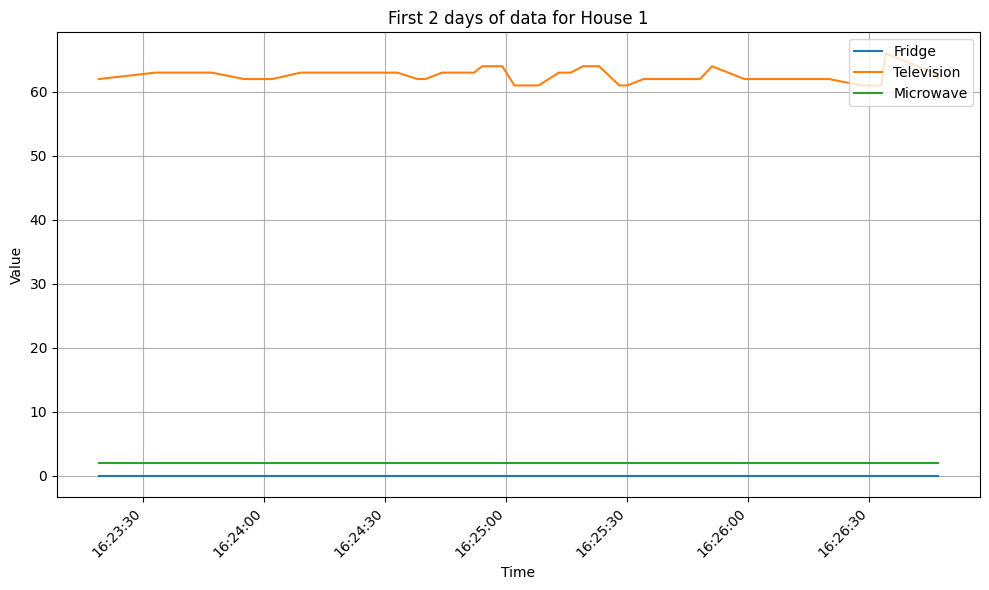

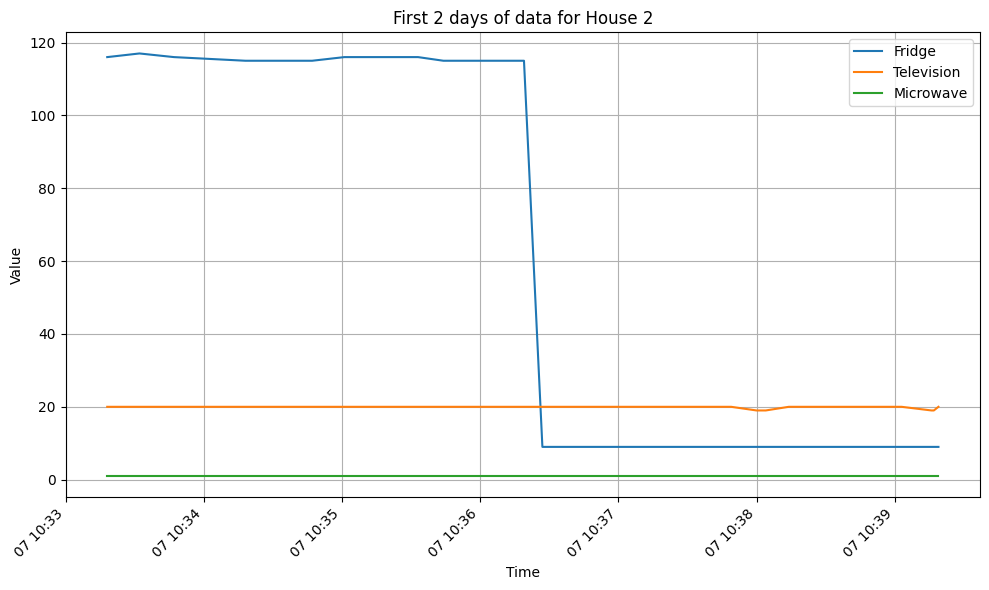

In [ ]:
def plot_df(df, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    df.plot(ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    plt.xticks(rotation=45)
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


for house, df in dfs.items():
    title = f"First 2 days of data for House {house}"
    plot_df(df.iloc[:48], title)


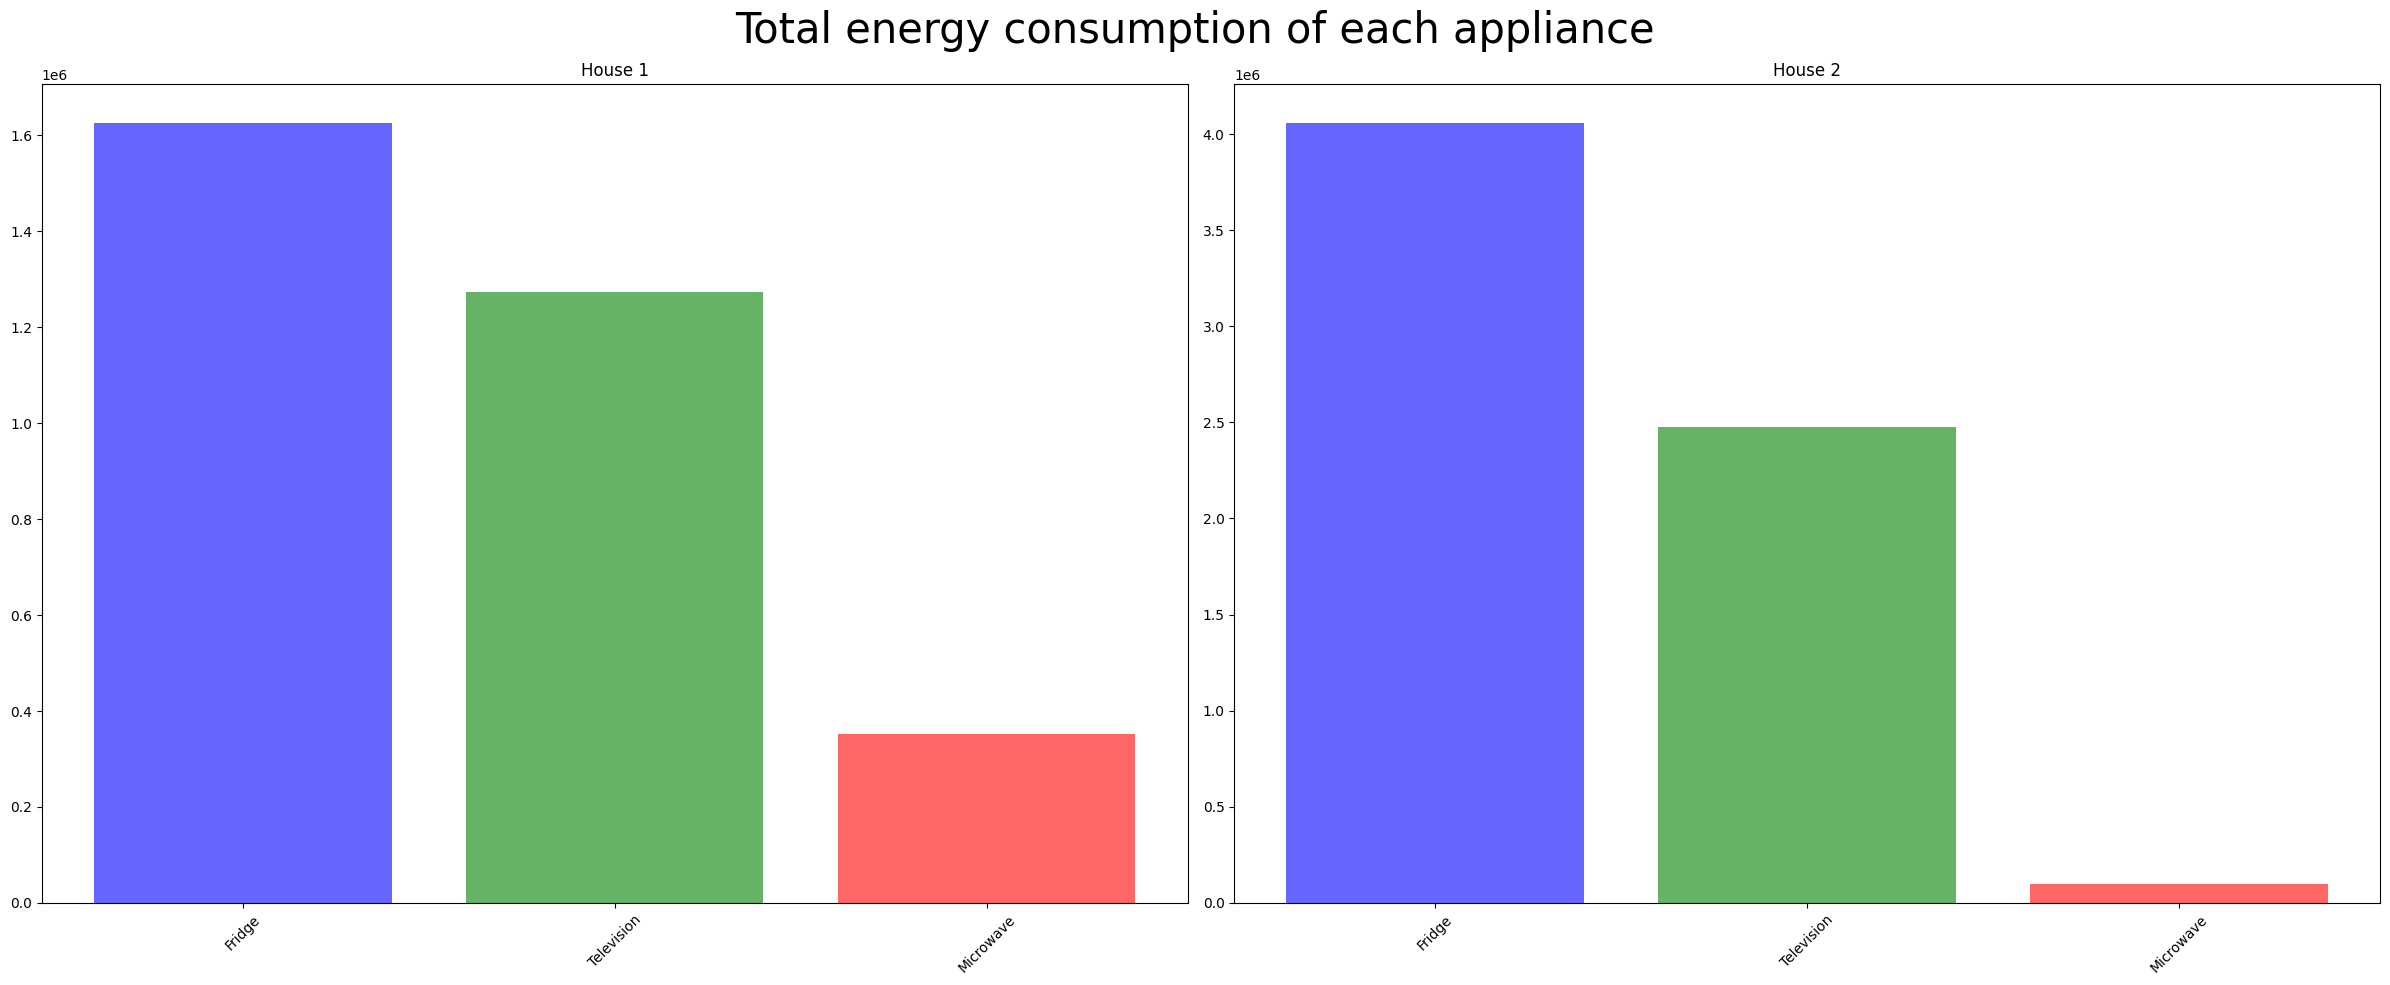

In [ ]:
colors = ['b', 'g', 'r']

# Plot total energy consumption of each appliance from all houses
fig, axes = plt.subplots(1, 2, figsize=(24, 10))
plt.suptitle('Total energy consumption of each appliance', fontsize=30)

for house, df in dfs.items():
    cons = df[df.columns.values[0:]].sum().sort_values(ascending=False)
    app = cons.index
    y_pos = np.arange(len(app))
    axes[house - 1].bar(y_pos, cons.values, alpha=0.6, color=colors[:len(app)])
    axes[house - 1].set_xticks(y_pos)
    axes[house - 1].set_xticklabels(app, rotation=45)
    axes[house - 1].set_title(f'House {house}')

plt.tight_layout()
plt.show()

## Data Preparation for LSTM Prediction Model

In [6]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# proportions for train and test sets
train_ratio = 0.7
test_ratio = 0.3

# Initialize dictionaries to store train and test DataFrames for each house
train_data = {}
test_data = {}

# Split the data for each house
for house, df in dfs.items():
    total_samples = len(df)
    train_size = int(total_samples * train_ratio)
    test_size = total_samples - train_size

    # Split the data
    train_data[house] = df.iloc[:train_size]
    test_data[house] = df.iloc[train_size:]



In [7]:
for house in range(1, 3):
    print(f"House {house}:")
    print(f"Train set length: {len(train_data[house])}")
    print(f"Test set length: {len(test_data[house])}")
    print()

House 1:
Train set length: 39034
Test set length: 16729

House 2:
Train set length: 37686
Test set length: 16152



In [8]:
def prepare_lstm_data(df):

   
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df.values)

    # Prepare the data in sequences for LSTM
    X = []
    y = []
    for i in range(len(scaled_data)):
        end_ix = i + 1
        if end_ix > len(scaled_data)-1:
            break
        seq_x, seq_y = scaled_data[i:end_ix], scaled_data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y), scaler

# Initialize dictionaries to store prepared data and scalers for each house
train_X, train_y, train_scalers = {}, {}, {}
test_X, test_y, test_scalers = {}, {}, {}


for house in range(1, 3):

    # training data
    train_X[house], train_y[house], train_scalers[house] = prepare_lstm_data(train_data[house])

    # testing data
    test_X[house], test_y[house], test_scalers[house] = prepare_lstm_data(test_data[house])

## Vanilla LSTM

In [25]:
# Vanilla LSTM model architecture

def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(units=64, input_shape=input_shape),
        Dense(units=3)
    ])
    return model

model = build_lstm_model(input_shape=(train_X[1].shape[1], train_X[1].shape[2]))

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 64)                17408     
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 17603 (68.76 KB)
Trainable params: 17603 (68.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:

learning_rate = 0.001

optimizer = Adam(learning_rate=learning_rate)

# Compile the vanilla LSTM model
model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])



In [ ]:


# Train the model

history = model.fit(train_X[1], train_y[1], epochs=100, batch_size=32, validation_data=(test_X[1], test_y[1]))



Epoch 1/100
1220/1220 [==============================] - 7s 4ms/step - loss: 0.0011 - accuracy: 0.9960 - val_loss: 0.0142 - val_accuracy: 0.9903
Epoch 2/100
1220/1220 [==============================] - 4s 3ms/step - loss: 3.1508e-04 - accuracy: 0.9988 - val_loss: 0.0140 - val_accuracy: 0.9903
Epoch 3/100
1220/1220 [==============================] - 5s 4ms/step - loss: 3.1753e-04 - accuracy: 0.9988 - val_loss: 0.0143 - val_accuracy: 0.9903
Epoch 4/100
1220/1220 [==============================] - 4s 3ms/step - loss: 3.1625e-04 - accuracy: 0.9988 - val_loss: 0.0139 - val_accuracy: 0.9903
Epoch 5/100
1220/1220 [==============================] - 4s 3ms/step - loss: 3.1598e-04 - accuracy: 0.9988 - val_loss: 0.0138 - val_accuracy: 0.9903
Epoch 6/100
1220/1220 [==============================] - 4s 3ms/step - loss: 3.0785e-04 - accuracy: 0.9988 - val_loss: 0.0133 - val_accuracy: 0.9903
Epoch 7/100
1220/1220 [==============================] - 5s 4ms/step - loss: 3.1311e-04 - accuracy: 0.9988 - v

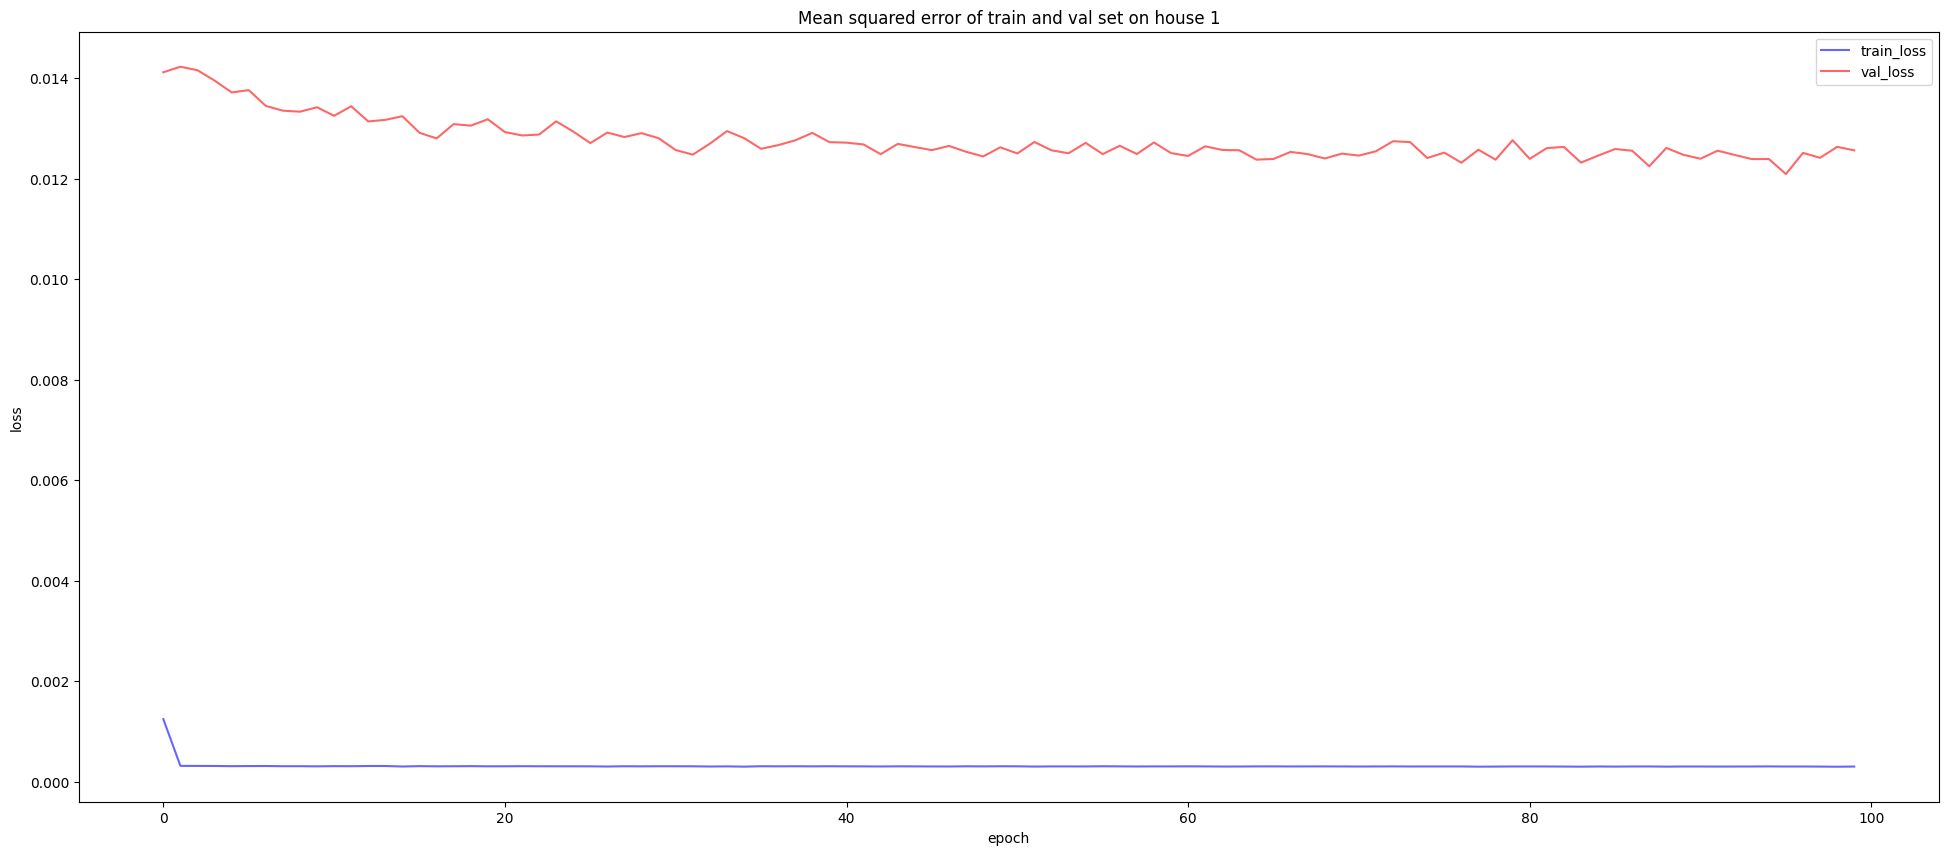

In [28]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
def plot_losses(train_loss, val_loss):
    plt.rcParams["figure.figsize"] = [24,10]
    plt.title('Mean squared error of train and val set on house 1')
    plt.plot( range(len(train_loss)), train_loss, color = 'b', alpha = 0.6, label='train_loss' )
    plt.plot( range(len( val_loss )), val_loss, color = 'r', alpha = 0.6, label='val_loss' )
    plt.xlabel( 'epoch' )
    plt.ylabel( 'loss' )
    plt.legend()

plot_losses(train_loss, val_loss)

In [ ]:
# Save the model
model.save('lstm_model.h5')


In [ ]:
# Evaluataccuracye the model on train data

loss, accuracy = model.evaluate(train_X[1], train_y[1])
print("Train Loss:", loss)
print("Train Accuracy: ", accuracy)

1220/1220 [==============================] - 2s 2ms/step - loss: 2.9537e-04 - accuracy: 0.9988
Train Loss: 0.0002953721268568188
Train Accuracy:  0.998821496963501


In [ ]:
# Evaluate the model on test data

loss, accuracy = model.evaluate(test_X[1], test_y[1])
print("Test Loss:", loss)
print("Test Accuracy: ", accuracy)

523/523 [==============================] - 1s 2ms/step - loss: 0.0125 - accuracy: 0.9885
Test Loss: 0.012496191076934338
Test Accuracy:  0.9885222315788269


In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



# Predict energy consumption using the trained LSTM model
predictions = model.predict(test_X[1])

# Inverse transform the predictions to get the original scale of energy consumption
predictions = test_scalers[1].inverse_transform(predictions)

# Inverse transform the actual values to get the original scale of energy consumption
actual_values = test_scalers[1].inverse_transform(test_y[1])



mse = mean_squared_error(actual_values, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_y[1], predictions)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)

523/523 [==============================] - 1s 2ms/step
Mean Squared Error (MSE): 685.6921434898487
Root Mean Squared Error (RMSE): 26.185724039824613
Mean Absolute Error (MAE): 20.083264447181914


In [ ]:
import pandas as pd
from sklearn.metrics import mean_absolute_error


mae_fridge = mean_absolute_error(actual_values[:, 0], predictions[:, 0])

timestamp_index = test_data[1].index[:len(predictions)]

fridge_output = pd.DataFrame({
    'Timestamp': timestamp_index,
    'Actual Values': actual_values[:, 0],
    'Predicted Values': predictions[:, 0]
})


fridge_output['MAE'] = mae_fridge

print("Fridge:")
print(fridge_output.head(20))


print(f"Mean Absolute Error (Fridge): {mae_fridge:.4f}")


Fridge:
             Timestamp  Actual Values  Predicted Values       MAE
0  2014-03-09 10:13:13           73.0         73.972717  1.498401
1  2014-03-09 10:13:15           73.0         73.019386  1.498401
2  2014-03-09 10:13:20           73.0         73.019386  1.498401
3  2014-03-09 10:13:27           73.0         73.019386  1.498401
4  2014-03-09 10:13:29           74.0         73.019386  1.498401
5  2014-03-09 10:13:34           73.0         73.972717  1.498401
6  2014-03-09 10:13:43           74.0         73.019386  1.498401
7  2014-03-09 10:13:48           72.0         73.972717  1.498401
8  2014-03-09 10:13:57           72.0         72.065117  1.498401
9  2014-03-09 10:14:02           74.0         72.065117  1.498401
10 2014-03-09 10:14:12           73.0         73.972717  1.498401
11 2014-03-09 10:14:16           73.0         73.019386  1.498401
12 2014-03-09 10:14:19           73.0         73.019386  1.498401
13 2014-03-09 10:14:26           74.0         73.019386  1.498401
14

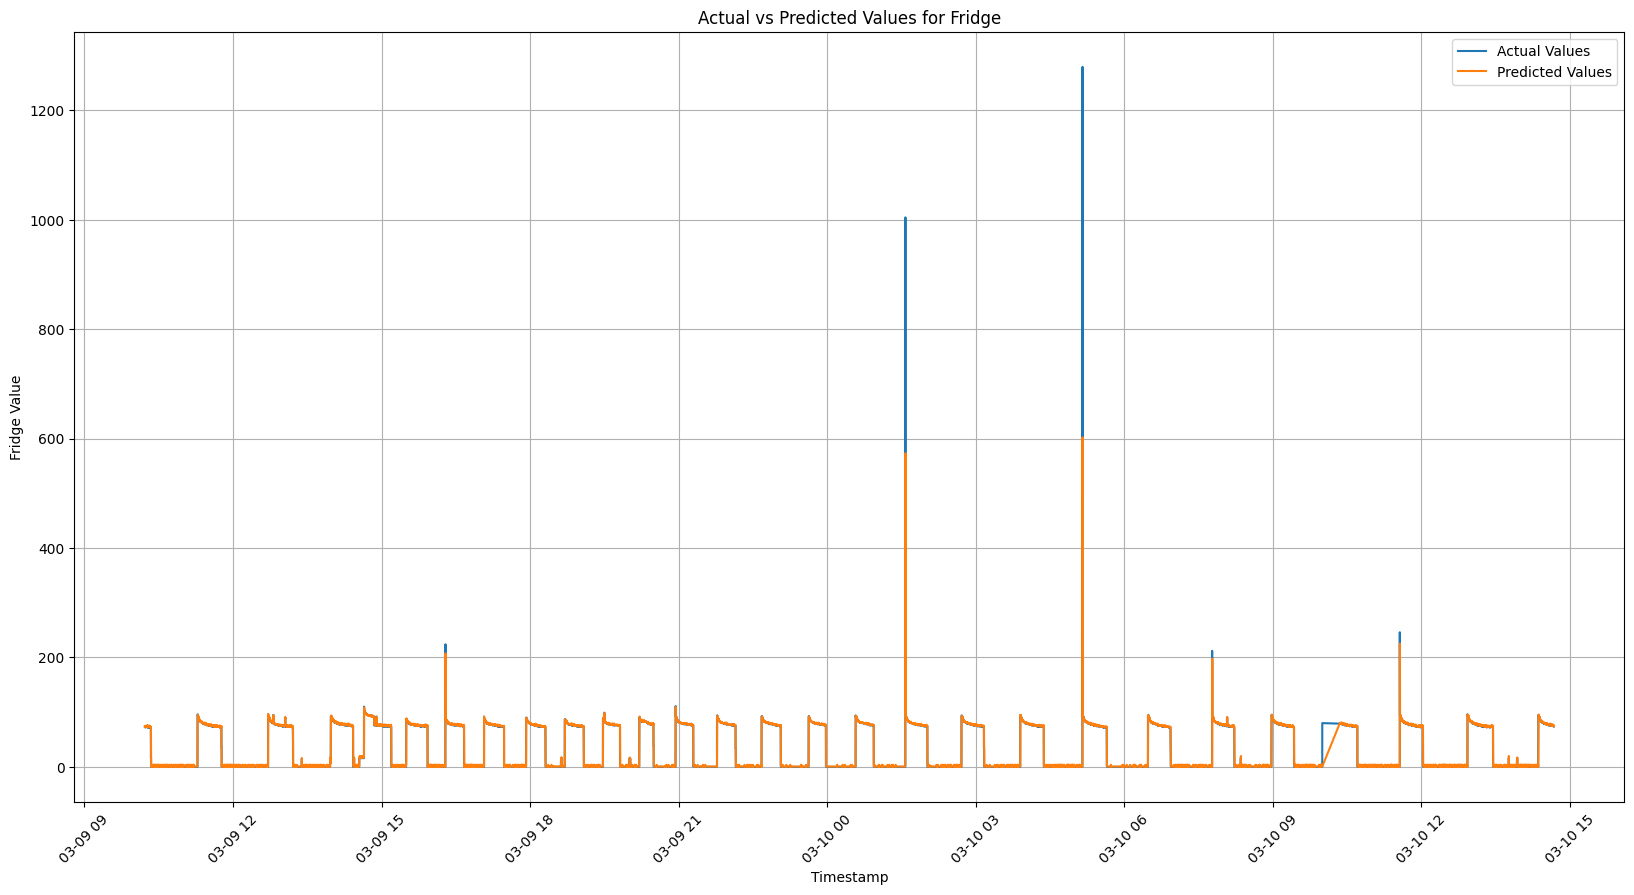

In [ ]:
# Plot actual vs predicted values for Fridge

plt.figure(figsize=(20, 10))
plt.plot(fridge_output['Timestamp'], fridge_output['Actual Values'], label='Actual Values')
plt.plot(fridge_output['Timestamp'], fridge_output['Predicted Values'], label='Predicted Values')
plt.title('Actual vs Predicted Values for Fridge')
plt.xlabel('Timestamp')
plt.ylabel('Fridge Value')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [ ]:
mae_tv = mean_absolute_error(actual_values[:, 1], predictions[:, 1])

timestamp_index = test_data[1].index[:len(predictions)]

tv_output = pd.DataFrame({
    'Timestamp': timestamp_index,
    'Actual Values': actual_values[:, 1],
    'Predicted Values': predictions[:, 1]
})


tv_output['MAE'] = mae_tv

print("Fridge:")
print(tv_output.head(20))


print(f"Mean Absolute Error (Television): {mae_tv:.4f}")


Fridge:
             Timestamp  Actual Values  Predicted Values      MAE
0  2014-03-09 10:13:13           21.0         21.009798  0.15996
1  2014-03-09 10:13:15           21.0         21.009802  0.15996
2  2014-03-09 10:13:20           21.0         21.009802  0.15996
3  2014-03-09 10:13:27           21.0         21.009802  0.15996
4  2014-03-09 10:13:29           21.0         21.009802  0.15996
5  2014-03-09 10:13:34           21.0         21.009798  0.15996
6  2014-03-09 10:13:43           21.0         21.009802  0.15996
7  2014-03-09 10:13:48           21.0         21.009798  0.15996
8  2014-03-09 10:13:57           21.0         21.009806  0.15996
9  2014-03-09 10:14:02           21.0         21.009806  0.15996
10 2014-03-09 10:14:12           21.0         21.009798  0.15996
11 2014-03-09 10:14:16           21.0         21.009802  0.15996
12 2014-03-09 10:14:19           21.0         21.009802  0.15996
13 2014-03-09 10:14:26           21.0         21.009802  0.15996
14 2014-03-09 10:

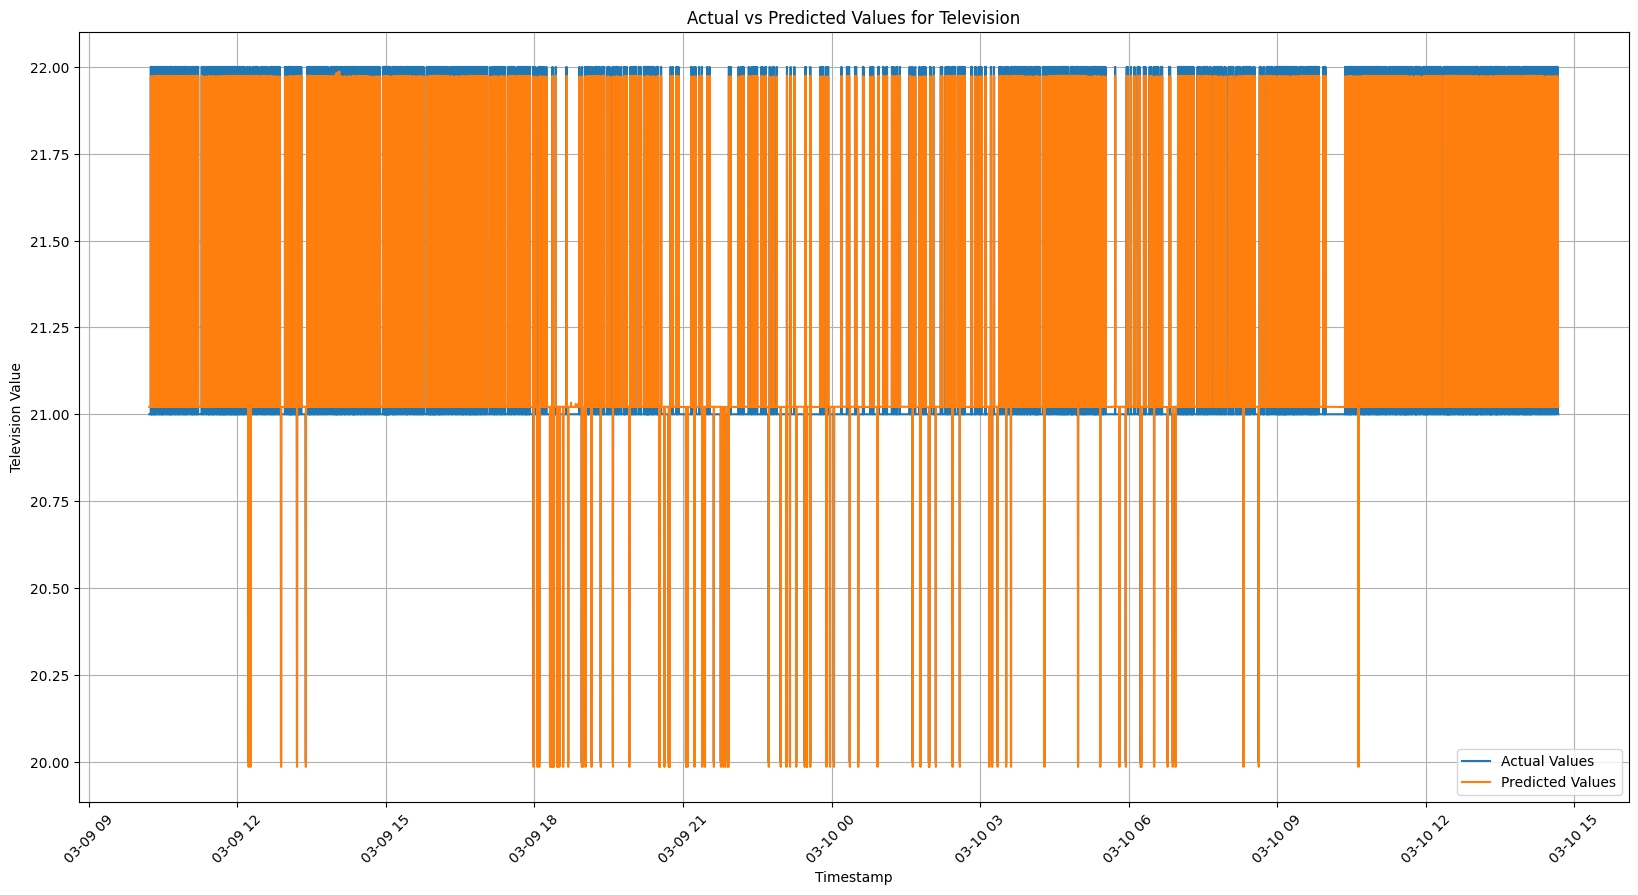

In [ ]:

# Plot actual vs predicted values for Television

plt.figure(figsize=(20, 10))
plt.plot(tv_output['Timestamp'], tv_output['Actual Values'], label='Actual Values')
plt.plot(tv_output['Timestamp'], tv_output['Predicted Values'], label='Predicted Values')
plt.title('Actual vs Predicted Values for Television')
plt.xlabel('Timestamp')
plt.ylabel('Television Value')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
from sklearn.metrics import mean_absolute_error


mae_microwave = mean_absolute_error(actual_values[:, 2], predictions[:, 2])

timestamp_index = test_data[1].index[:len(predictions)]

microwave_output = pd.DataFrame({
    'Timestamp': timestamp_index,
    'Actual Values': actual_values[:, 2],
    'Predicted Values': predictions[:, 2]
})

# Add the accuracy metric (MAE) to the DataFrame
microwave_output['MAE'] = mae_microwave

print("Fridge:")
print(microwave_output.head(20))

# Print the Mean Absolute Error
print(f"Mean Absolute Error (Television): {mae_microwave:.4f}")


Fridge:
             Timestamp  Actual Values  Predicted Values       MAE
0  2014-03-09 10:13:13            2.0          3.967083  5.693546
1  2014-03-09 10:13:15            2.0          3.963562  5.693546
2  2014-03-09 10:13:20            2.0          3.963562  5.693546
3  2014-03-09 10:13:27            2.0          3.963562  5.693546
4  2014-03-09 10:13:29            2.0          3.963562  5.693546
5  2014-03-09 10:13:34            2.0          3.967083  5.693546
6  2014-03-09 10:13:43            2.0          3.963562  5.693546
7  2014-03-09 10:13:48            2.0          3.967083  5.693546
8  2014-03-09 10:13:57            2.0          3.960037  5.693546
9  2014-03-09 10:14:02            2.0          3.960037  5.693546
10 2014-03-09 10:14:12            2.0          3.967083  5.693546
11 2014-03-09 10:14:16            2.0          3.963562  5.693546
12 2014-03-09 10:14:19            2.0          3.963562  5.693546
13 2014-03-09 10:14:26            2.0          3.963562  5.693546
14

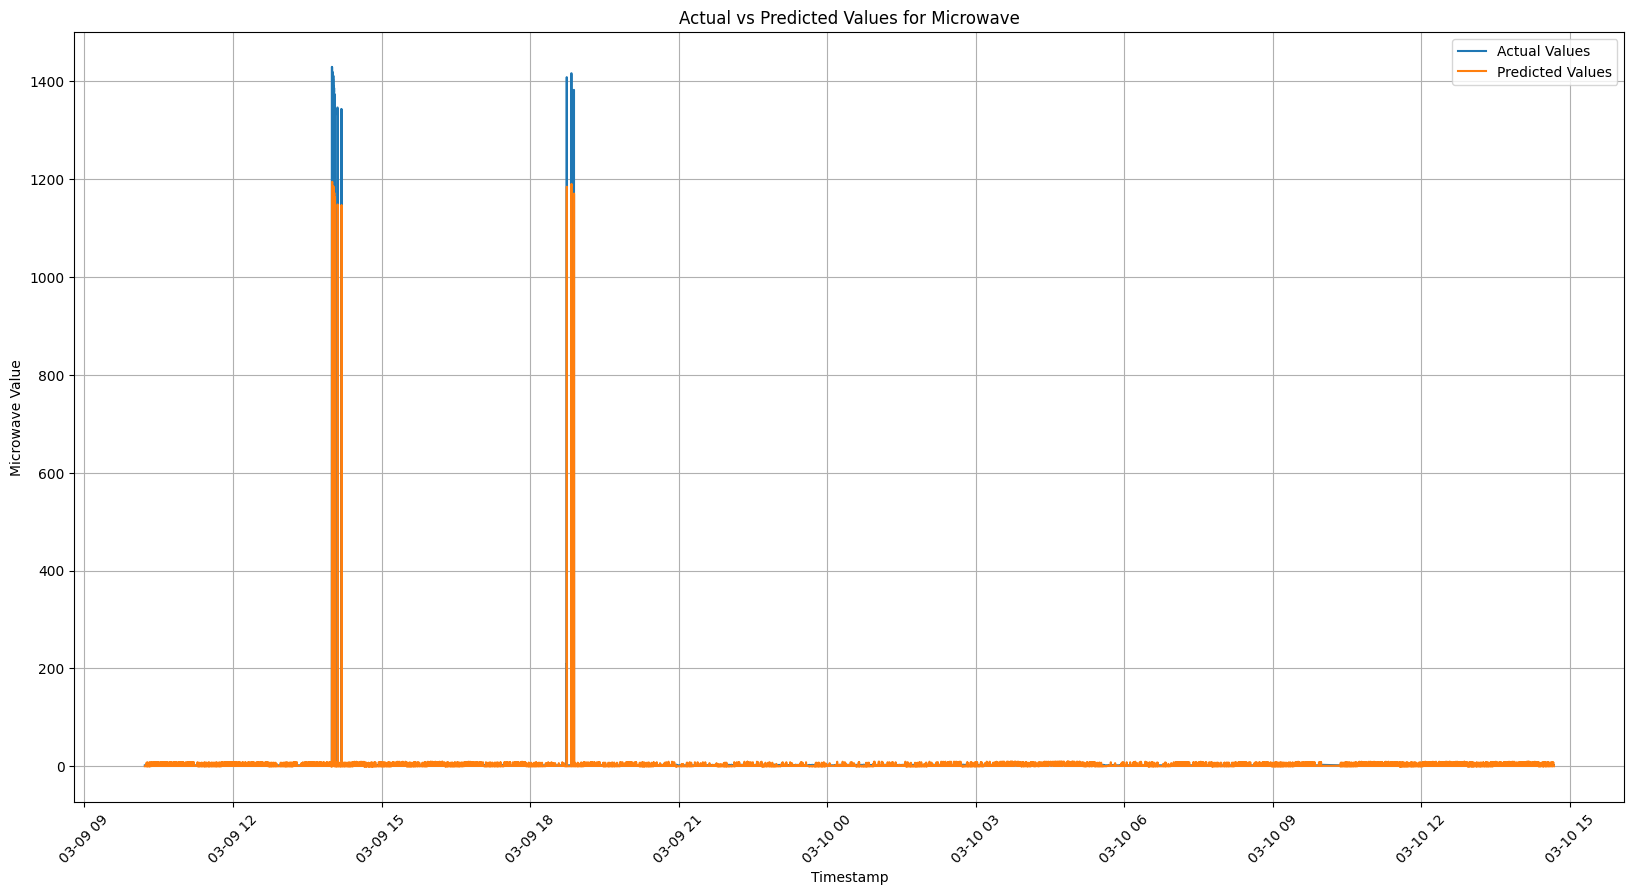

In [ ]:
# Plot actual vs predicted values for Microwave

plt.figure(figsize=(20, 10))
plt.plot(microwave_output['Timestamp'], microwave_output['Actual Values'], label='Actual Values')
plt.plot(microwave_output['Timestamp'], microwave_output['Predicted Values'], label='Predicted Values')
plt.title('Actual vs Predicted Values for Microwave')
plt.xlabel('Timestamp')
plt.ylabel('Microwave Value')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


## Using the vanilla LSTM model we have just trained on house 1 to predict energy consumtion on house 2

In [ ]:
# Load and preprocess data for house 2
house_2_data = read_merge_data(2)
house_2_X, house_2_y, house_2_scaler = prepare_lstm_data(house_2_data)



# Predict energy consumption for house 2 using the Vanilla trained model on house 1
house_2_predictions = model.predict(house_2_X)



# Inverse transform the predictions to get the original scale of energy consumption
house_2_predictions = house_2_scaler.inverse_transform(house_2_predictions)

house_2_y = house_2_scaler.inverse_transform(house_2_y)



mse_house_2 = mean_squared_error(house_2_y, house_2_predictions)
rmse_house_2 = np.sqrt(mse_house_2)
mae_house_2 = mean_absolute_error(house_2_y, house_2_predictions)

print("House 2 Prediction Metrics:")
print("Mean Squared Error (MSE):", mse_house_2)
print("Root Mean Squared Error (RMSE):", rmse_house_2)
print("Mean Absolute Error (MAE):", mae_house_2)


1683/1683 [==============================] - 3s 2ms/step
House 2 Prediction Metrics:
Mean Squared Error (MSE): 272.9274841875866
Root Mean Squared Error (RMSE): 16.520517067803496
Mean Absolute Error (MAE): 2.55906810800114


In [ ]:
# Determine the minimum length among timestamp_index, house_2_y, and house_2_predictions
min_length = min(len(timestamp_index), len(house_2_y), len(house_2_predictions))



# Slice the arrays to match the minimum length
timestamp_index = timestamp_index[:min_length]
house_2_y = house_2_y[:min_length]
house_2_predictions = house_2_predictions[:min_length]




fridge_output = pd.DataFrame({
    'Timestamp': timestamp_index,
    'Actual Values': house_2_y[:, 0],
    'Predicted Values': house_2_predictions[:, 0]
})

# Print the DataFrame for the Microwave appliance
print("Fridge:")
print(fridge_output.head(15))


Fridge:
             Timestamp  Actual Values  Predicted Values
0  2014-03-09 10:13:13          117.0        113.591240
1  2014-03-09 10:13:15          116.0        114.509796
2  2014-03-09 10:13:20          115.0        113.591240
3  2014-03-09 10:13:27          115.0        112.671700
4  2014-03-09 10:13:29          115.0        112.671700
5  2014-03-09 10:13:34          116.0        112.671700
6  2014-03-09 10:13:43          116.0        113.591240
7  2014-03-09 10:13:48          116.0        113.591240
8  2014-03-09 10:13:57          116.0        113.591240
9  2014-03-09 10:14:02          116.0        113.591240
10 2014-03-09 10:14:12          115.0        113.591240
11 2014-03-09 10:14:16          115.0        112.671700
12 2014-03-09 10:14:19          115.0        112.671700
13 2014-03-09 10:14:26          115.0        112.671700
14 2014-03-09 10:14:31          115.0        112.671700


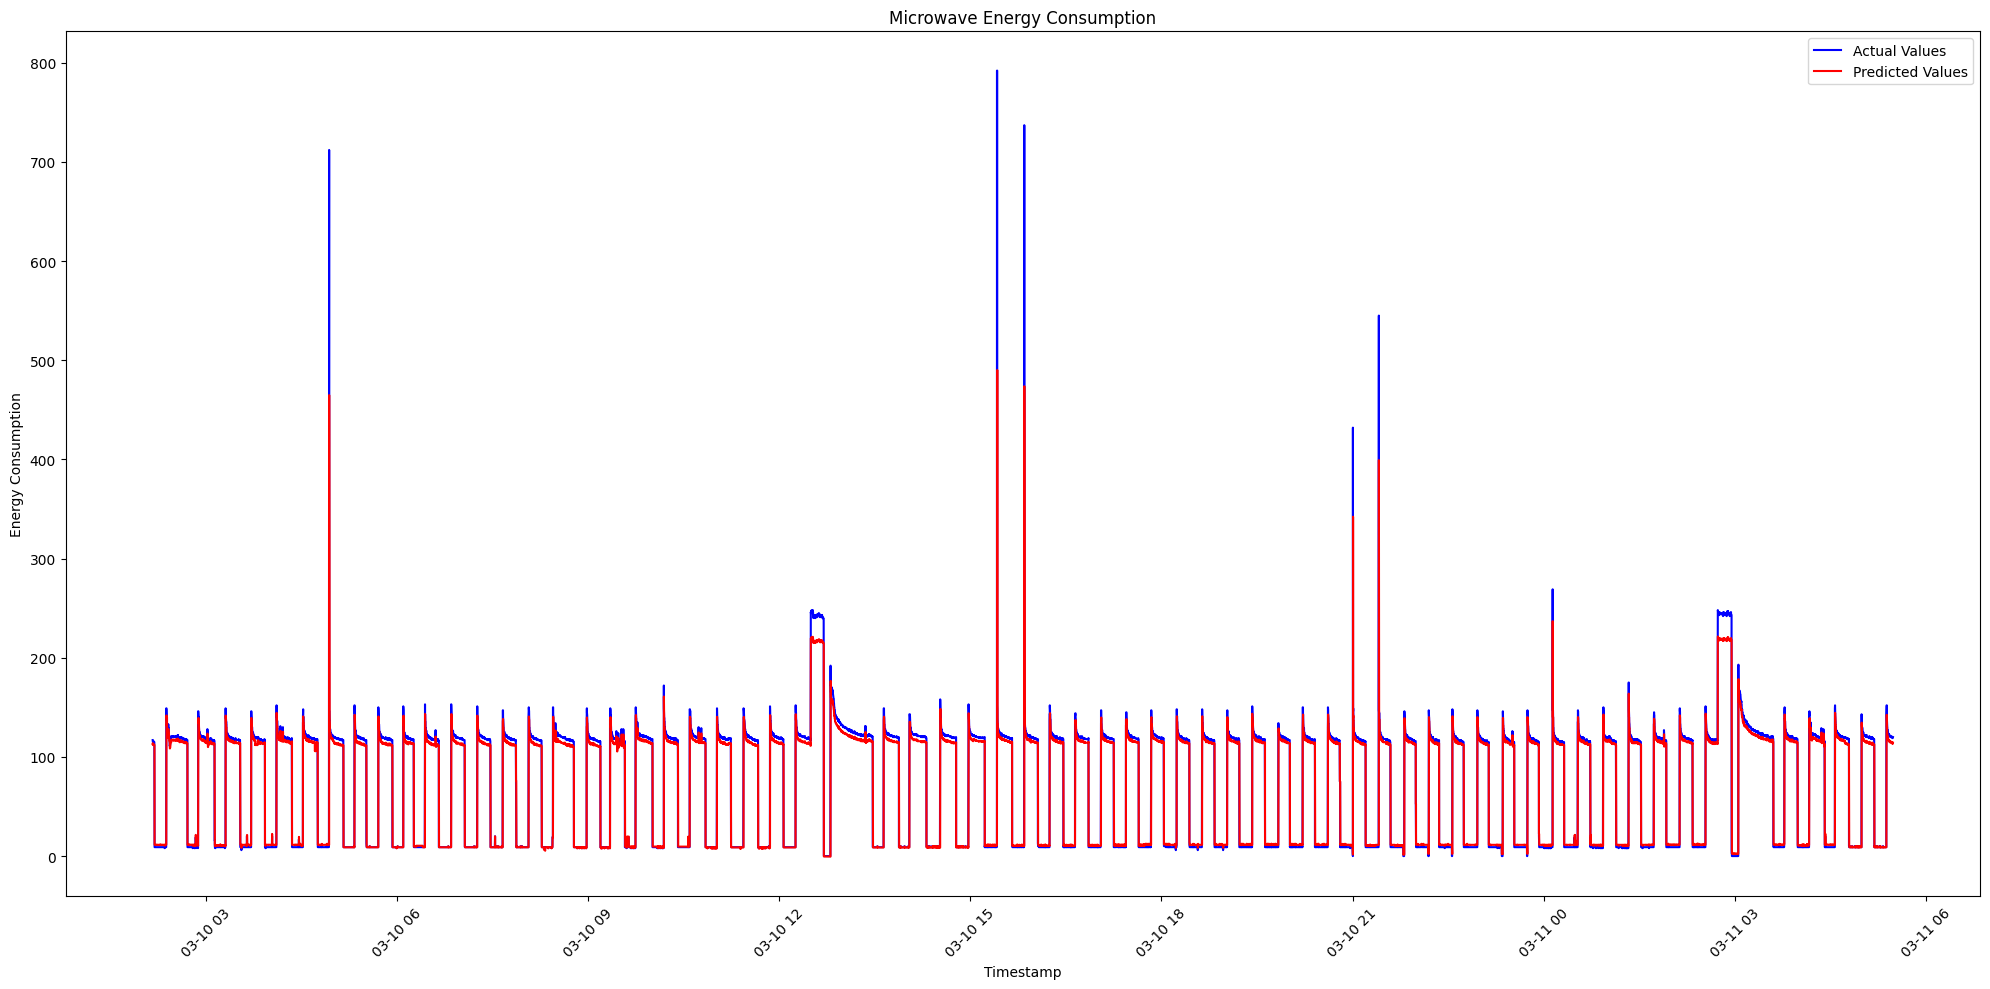

In [ ]:
import matplotlib.pyplot as plt

# Plot actual and predicted values
plt.figure(figsize=(20, 10))
plt.plot(fridge_output['Timestamp'], fridge_output['Actual Values'], label='Actual Values', color='blue')
plt.plot(fridge_output['Timestamp'], fridge_output['Predicted Values'], label='Predicted Values', color='red')
plt.title('Microwave Energy Consumption')
plt.xlabel('Timestamp')
plt.ylabel('Energy Consumption')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
min_length = min(len(timestamp_index), len(house_2_y), len(house_2_predictions))

# Slice the arrays to match the minimum length
timestamp_index = timestamp_index[:min_length]
house_2_y = house_2_y[:min_length]
house_2_predictions = house_2_predictions[:min_length]



tv_output = pd.DataFrame({
    'Timestamp': timestamp_index,
    'Actual Values': house_2_y[:, 1],
    'Predicted Values': house_2_predictions[:, 1]
})


print("Television:")
print(tv_output.head(20))


Television:
             Timestamp  Actual Values  Predicted Values
0  2014-03-10 02:09:45           20.0         20.592707
1  2014-03-10 02:09:48           20.0         20.592434
2  2014-03-10 02:09:59           20.0         20.592707
3  2014-03-10 02:10:02           20.0         20.592979
4  2014-03-10 02:10:14           20.0         20.592979
5  2014-03-10 02:10:16           20.0         20.592979
6  2014-03-10 02:10:18           20.0         20.592707
7  2014-03-10 02:10:28           20.0         20.592707
8  2014-03-10 02:10:31           20.0         20.592707
9  2014-03-10 02:10:33           20.0         20.592707
10 2014-03-10 02:10:45           20.0         20.592707
11 2014-03-10 02:10:47           20.0         20.592979
12 2014-03-10 02:10:59           20.0         20.592979
13 2014-03-10 02:11:01           20.0         20.592979
14 2014-03-10 02:11:13           20.0         20.592979
15 2014-03-10 02:11:16           20.0         20.592979
16 2014-03-10 02:11:19           20.

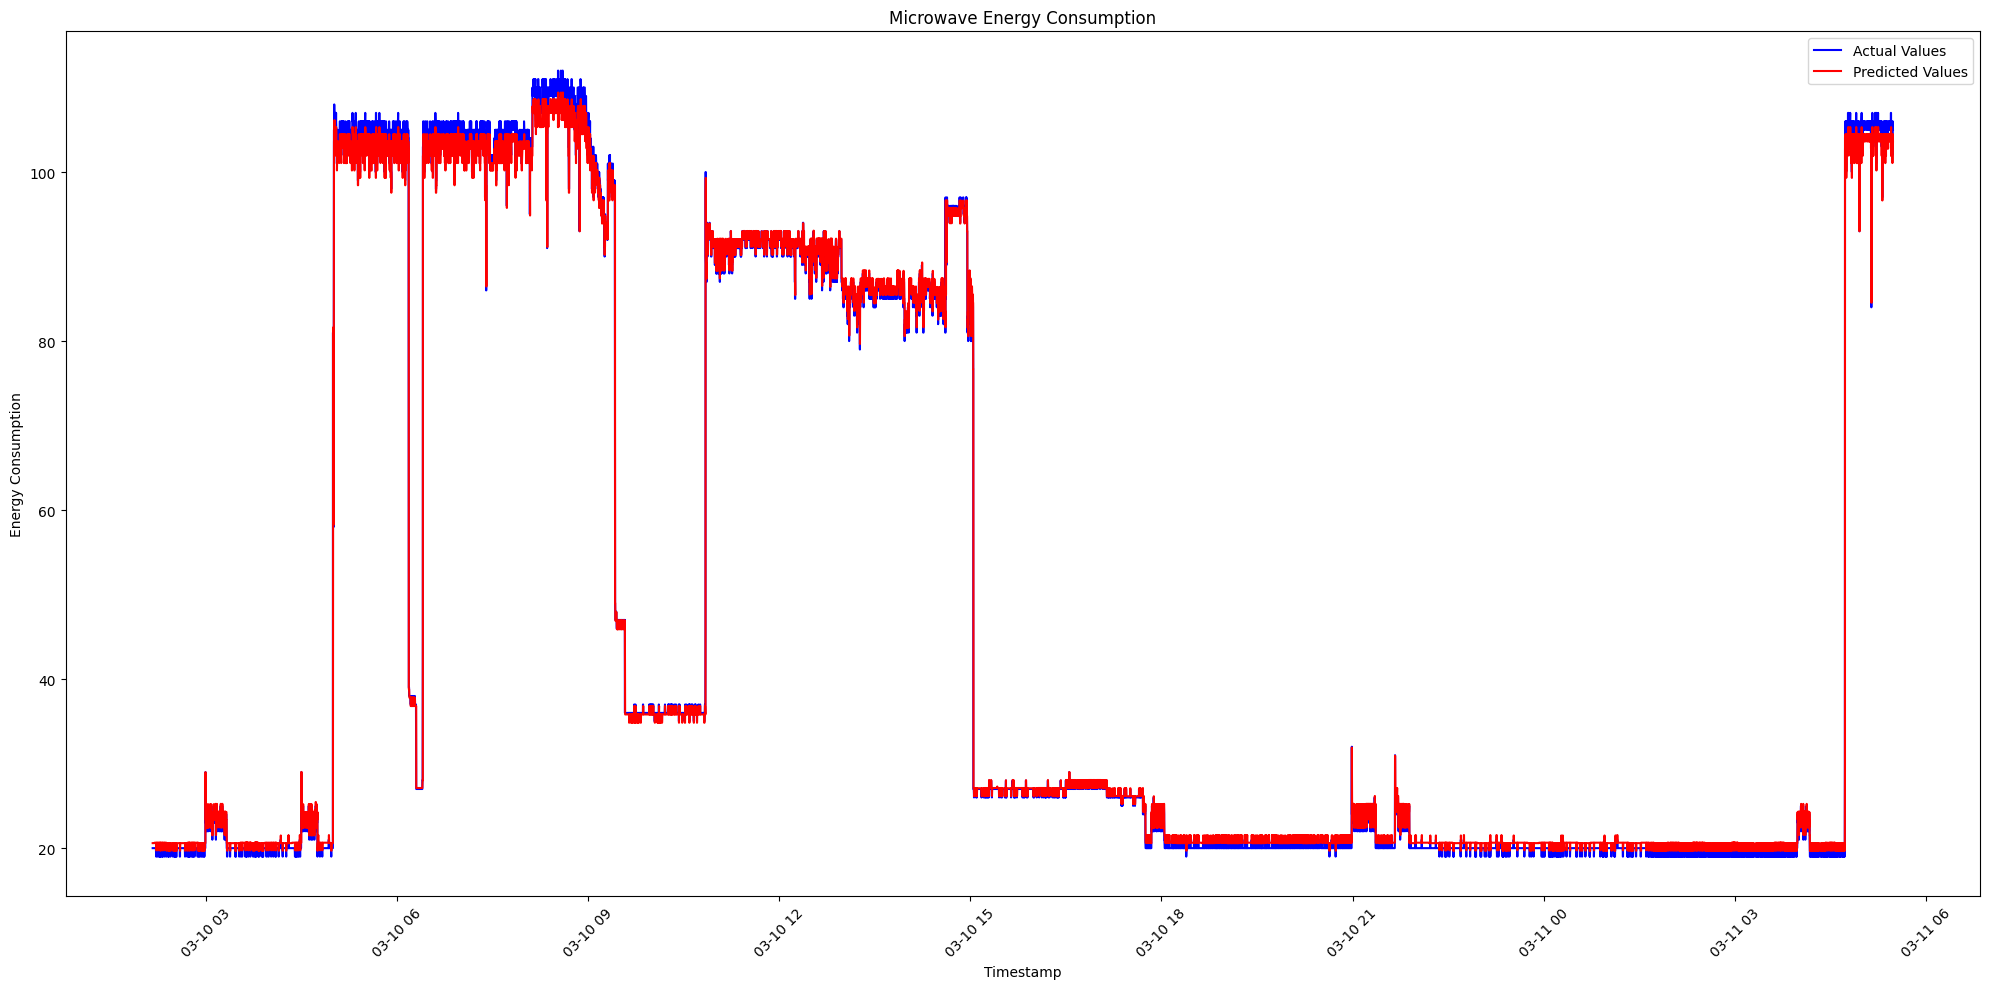

In [ ]:
import matplotlib.pyplot as plt

# Plot actual and predicted values
plt.figure(figsize=(20, 10))
plt.plot(tv_output['Timestamp'], tv_output['Actual Values'], label='Actual Values', color='blue')
plt.plot(tv_output['Timestamp'], tv_output['Predicted Values'], label='Predicted Values', color='red')
plt.title('Microwave Energy Consumption')
plt.xlabel('Timestamp')
plt.ylabel('Energy Consumption')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
min_length = min(len(timestamp_index), len(house_2_y), len(house_2_predictions))


timestamp_index = timestamp_index[:min_length]
house_2_y = house_2_y[:min_length]
house_2_predictions = house_2_predictions[:min_length]


microwave_output = pd.DataFrame({
    'Timestamp': timestamp_index,
    'Actual Values': house_2_y[:, 2],
    'Predicted Values': house_2_predictions[:, 2]
})


print("Microwave:")
print(microwave_output.head(20))


Microwave:
             Timestamp  Actual Values  Predicted Values
0  2014-03-10 02:09:45            1.0          2.684291
1  2014-03-10 02:09:48            1.0          2.674863
2  2014-03-10 02:09:59            1.0          2.684291
3  2014-03-10 02:10:02            1.0          2.693611
4  2014-03-10 02:10:14            1.0          2.693611
5  2014-03-10 02:10:16            1.0          2.693611
6  2014-03-10 02:10:18            1.0          2.684291
7  2014-03-10 02:10:28            1.0          2.684291
8  2014-03-10 02:10:31            1.0          2.684291
9  2014-03-10 02:10:33            1.0          2.684291
10 2014-03-10 02:10:45            1.0          2.684291
11 2014-03-10 02:10:47            1.0          2.693611
12 2014-03-10 02:10:59            1.0          2.693611
13 2014-03-10 02:11:01            1.0          2.693611
14 2014-03-10 02:11:13            1.0          2.693611
15 2014-03-10 02:11:16            1.0          2.693611
16 2014-03-10 02:11:19            1.0

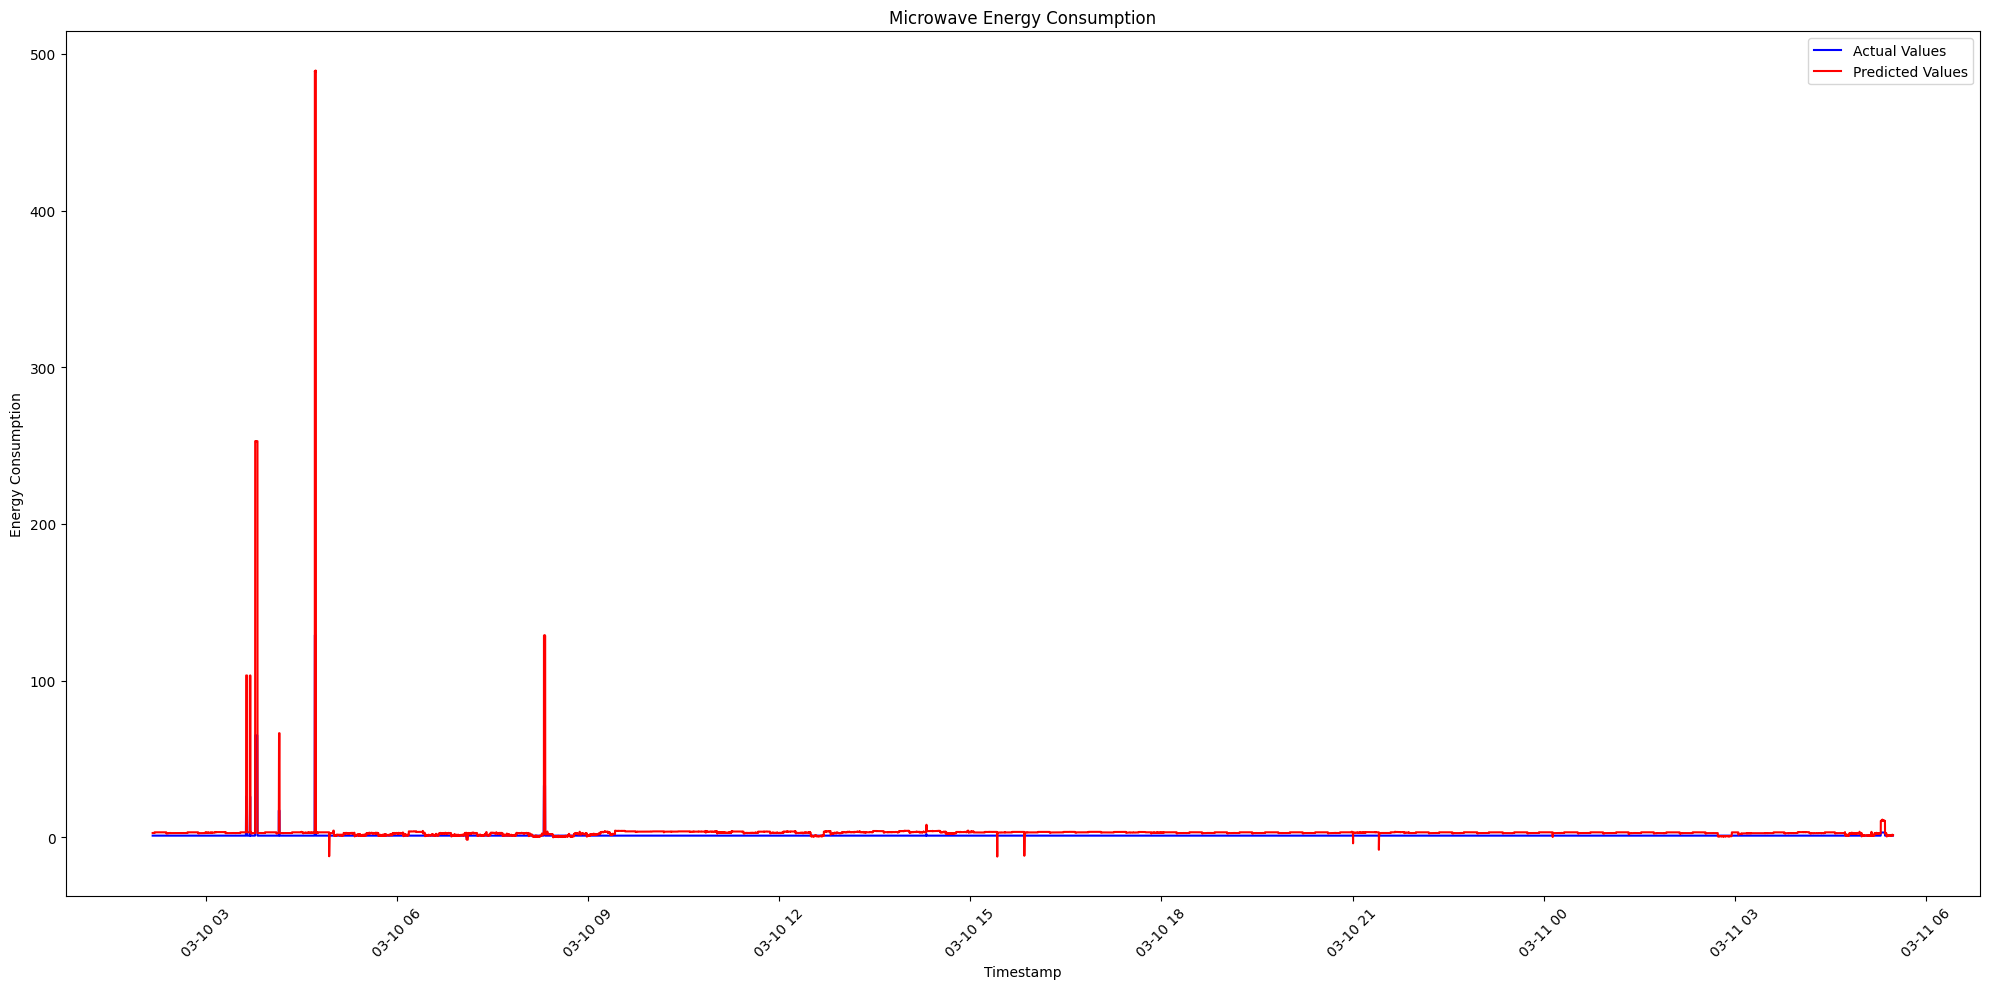

In [ ]:
import matplotlib.pyplot as plt

# Plot actual and predicted values
plt.figure(figsize=(20, 10))
plt.plot(microwave_output['Timestamp'], microwave_output['Actual Values'], label='Actual Values', color='blue')
plt.plot(microwave_output['Timestamp'], microwave_output['Predicted Values'], label='Predicted Values', color='red')
plt.title('Microwave Energy Consumption')
plt.xlabel('Timestamp')
plt.ylabel('Energy Consumption')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## STACKED LSTM

In [15]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Define a function to build a stacked LSTM model
def stacked_lstm(input_shape):

    stacked_model = Sequential()
    stacked_model.add(LSTM(units=64, activation='relu', return_sequences=True, input_shape=input_shape))
    stacked_model.add(LSTM(units=64, activation='relu'))
    stacked_model.add(Dense(units=3))
    return stacked_model


stacked_model = stacked_lstm(input_shape=(train_X[1].shape[1], train_X[1].shape[2]))


stacked_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 1, 64)             17408     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 50627 (197.76 KB)
Trainable params: 50627 (197.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
# Define the learning rate
learning_rate = 0.001

optimizer = Adam(learning_rate=learning_rate)

# Compile the vanilla LSTM model
stacked_model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])




In [17]:

history_stacked= stacked_model.fit(train_X[1], train_y[1], epochs=100, batch_size=32, validation_data=(test_X[1], test_y[1]))



Epoch 1/100
1220/1220 [==============================] - 8s 4ms/step - loss: 0.0014 - accuracy: 0.9975 - val_loss: 0.0150 - val_accuracy: 0.9904
Epoch 2/100
1220/1220 [==============================] - 4s 3ms/step - loss: 3.3239e-04 - accuracy: 0.9989 - val_loss: 0.0142 - val_accuracy: 0.9903
Epoch 3/100
1220/1220 [==============================] - 4s 3ms/step - loss: 3.2753e-04 - accuracy: 0.9988 - val_loss: 0.0138 - val_accuracy: 0.9902
Epoch 4/100
1220/1220 [==============================] - 4s 3ms/step - loss: 3.2296e-04 - accuracy: 0.9988 - val_loss: 0.0129 - val_accuracy: 0.9903
Epoch 5/100
1220/1220 [==============================] - 4s 3ms/step - loss: 3.1782e-04 - accuracy: 0.9987 - val_loss: 0.0132 - val_accuracy: 0.9903
Epoch 6/100
1220/1220 [==============================] - 4s 3ms/step - loss: 3.2338e-04 - accuracy: 0.9988 - val_loss: 0.0127 - val_accuracy: 0.9903
Epoch 7/100
1220/1220 [==============================] - 4s 3ms/step - loss: 3.1922e-04 - accuracy: 0.9988 - v

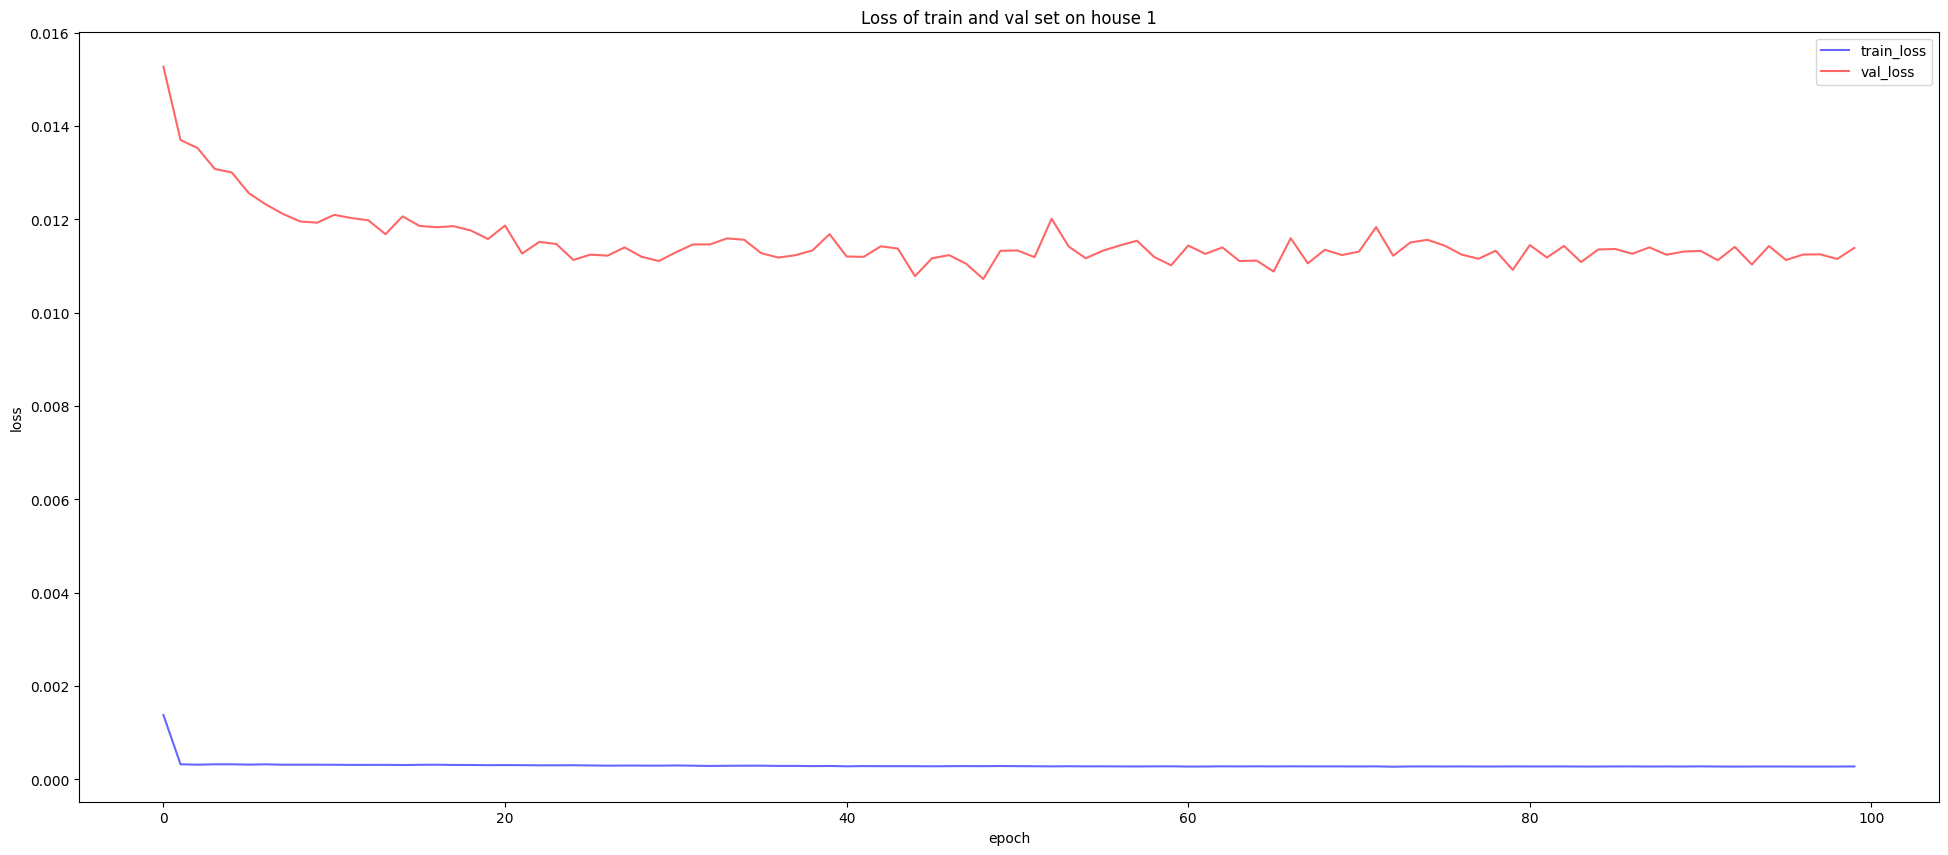

In [ ]:
train_loss = history_stacked.history['loss']
val_loss = history_stacked.history['val_loss']
def plot_losses(train_loss, val_loss):
    plt.rcParams["figure.figsize"] = [24,10]
    plt.title('Loss of train and val set on house 1')
    plt.plot( range(len(train_loss)), train_loss, color = 'b', alpha = 0.6, label='train_loss' )
    plt.plot( range(len( val_loss )), val_loss, color = 'r', alpha = 0.6, label='val_loss' )
    plt.xlabel( 'epoch' )
    plt.ylabel( 'loss' )
    plt.legend()

plot_losses(train_loss, val_loss)

In [ ]:
# Evaluataccuracye the model on Train data
loss, accuracy = stacked_model.evaluate(train_X[1], train_y[1])
print("Train Loss:", loss)
print("Train Accuracy: ", accuracy)

1220/1220 [==============================] - 2s 2ms/step - loss: 2.6916e-04 - accuracy: 0.9989
Train Loss: 0.00026916497154161334
Train Accuracy:  0.9989240169525146


In [ ]:
# Evaluate the model on test data
loss, accuracy = stacked_model.evaluate(test_X[1], test_y[1])
print("Test Loss:", loss)
print("Test Accuracy: ", accuracy)

523/523 [==============================] - 1s 2ms/step - loss: 0.0114 - accuracy: 0.9913
Test Loss: 0.011391137726604939
Test Accuracy:  0.9912720918655396


In [ ]:
# Save the model
stacked_model.save('stacked_model.h5')


In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



# Predict energy consumption using the trained stacked LSTM model
predictions = stacked_model.predict(test_X[1])



# Inverse transform predictions using the scaler
predictions = test_scalers[1].inverse_transform(predictions)


# Inverse transform the actual values to get the original scale of energy consumption
actual_values = test_scalers[1].inverse_transform(test_y[1])




mse = mean_squared_error(actual_values, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_y[1], predictions)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)

523/523 [==============================] - 1s 2ms/step
Mean Squared Error (MSE): 712.9804553235678
Root Mean Squared Error (RMSE): 26.701693866186986
Mean Absolute Error (MAE): 22.144727406601707


In [ ]:
import pandas as pd
from sklearn.metrics import mean_absolute_error


mae_fridge = mean_absolute_error(actual_values[:, 0], predictions[:, 0])

timestamp_index = test_data[1].index[:len(predictions)]

fridge_output = pd.DataFrame({
    'Timestamp': timestamp_index,
    'Actual Values': actual_values[:, 0],
    'Predicted Values': predictions[:, 0]
})

# Add the accuracy metric (MAE) to the DataFrame
fridge_output['MAE'] = mae_fridge

print("Fridge:")
print(fridge_output.head(20))

# Print the Mean Absolute Error
print(f"Mean Absolute Error (Fridge): {mae_fridge:.4f}")


Fridge:
             Timestamp  Actual Values  Predicted Values       MAE
0  2014-03-09 10:13:13           73.0         73.252205  1.274364
1  2014-03-09 10:13:15           73.0         72.296783  1.274364
2  2014-03-09 10:13:20           73.0         72.296783  1.274364
3  2014-03-09 10:13:27           73.0         72.296783  1.274364
4  2014-03-09 10:13:29           74.0         72.296783  1.274364
5  2014-03-09 10:13:34           73.0         73.252205  1.274364
6  2014-03-09 10:13:43           74.0         72.296783  1.274364
7  2014-03-09 10:13:48           72.0         73.252205  1.274364
8  2014-03-09 10:13:57           72.0         71.340286  1.274364
9  2014-03-09 10:14:02           74.0         71.340286  1.274364
10 2014-03-09 10:14:12           73.0         73.252205  1.274364
11 2014-03-09 10:14:16           73.0         72.296783  1.274364
12 2014-03-09 10:14:19           73.0         72.296783  1.274364
13 2014-03-09 10:14:26           74.0         72.296783  1.274364
14

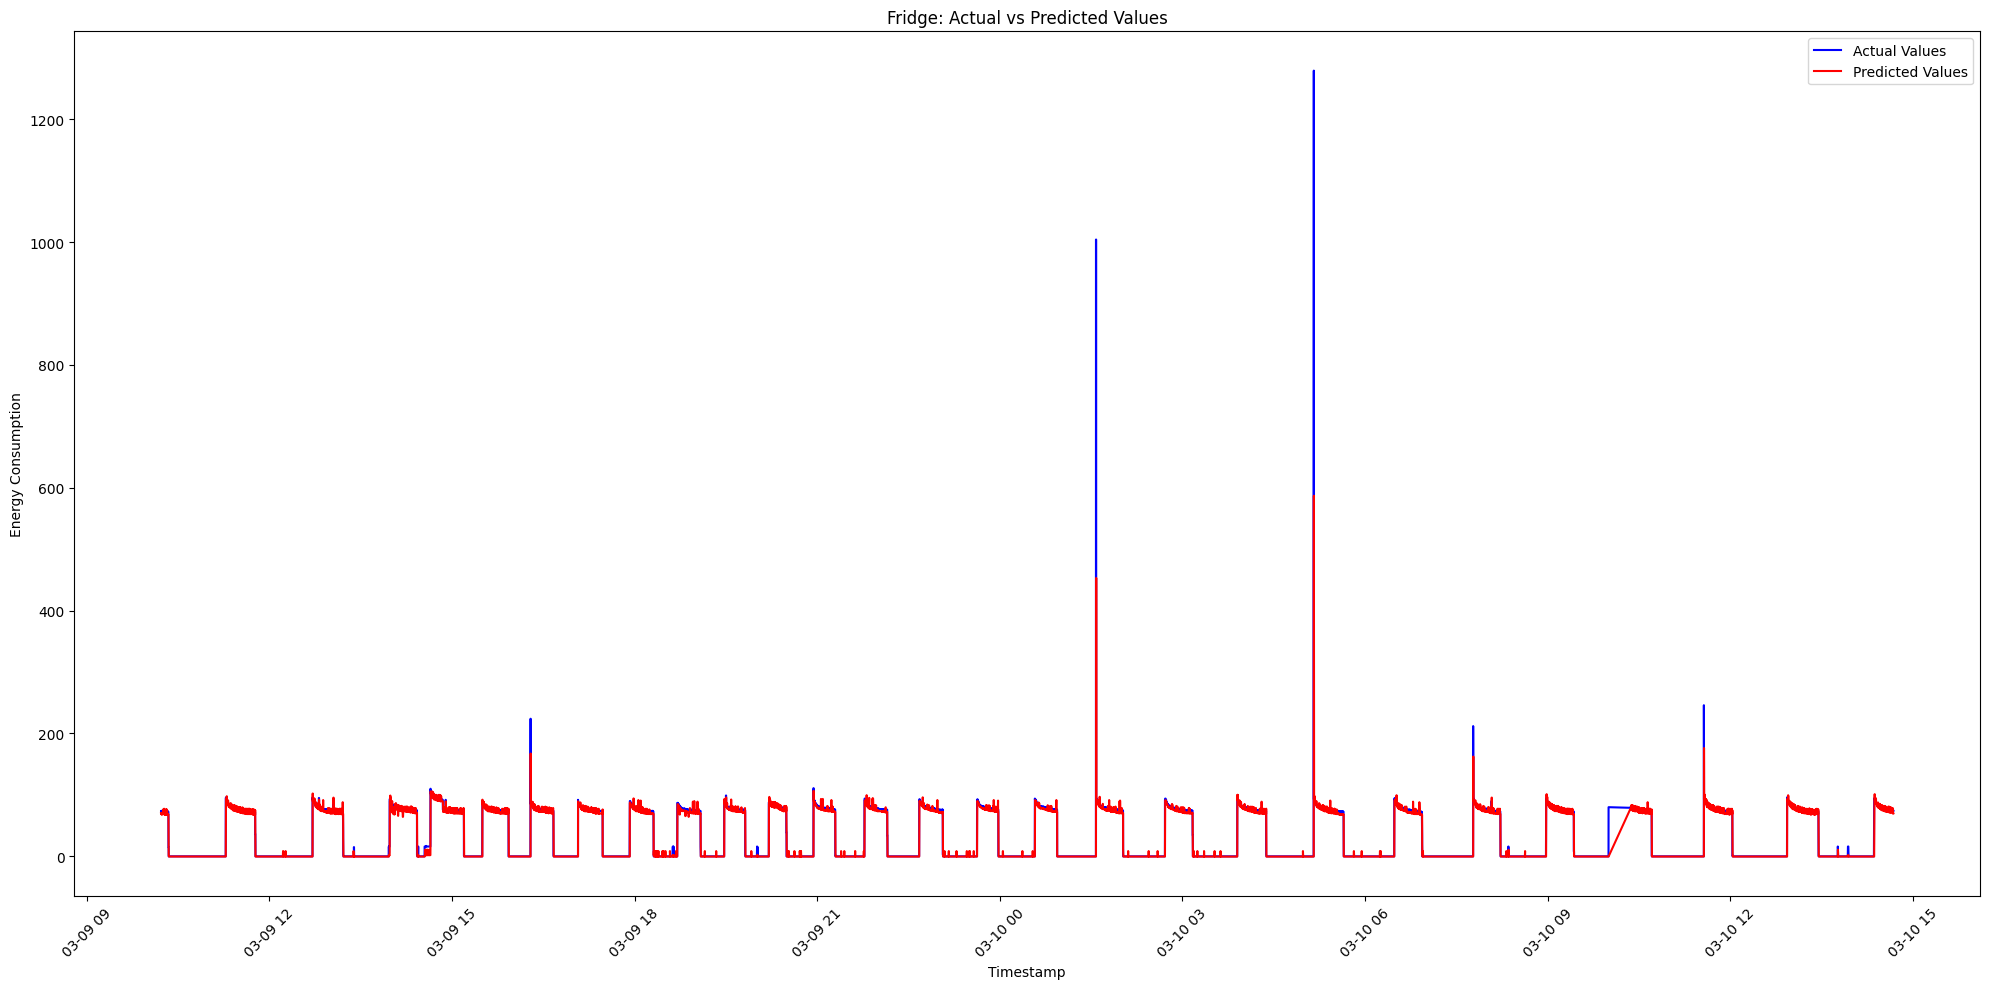

In [ ]:
# Plot actual and predicted values

plt.figure(figsize=(20, 10))
plt.plot(fridge_output['Timestamp'], fridge_output['Actual Values'], label='Actual Values', color='blue')
plt.plot(fridge_output['Timestamp'], fridge_output['Predicted Values'], label='Predicted Values', color='red')
plt.title('Fridge: Actual vs Predicted Values')
plt.xlabel('Timestamp')
plt.ylabel('Energy Consumption')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [25]:
import pandas as pd
from sklearn.metrics import mean_absolute_error


mae_tv = mean_absolute_error(actual_values[:, 1], predictions[:, 1])

timestamp_index = test_data[1].index[:len(predictions)]

tv_output = pd.DataFrame({
    'Timestamp': timestamp_index,
    'Actual Values': actual_values[:, 1],
    'Predicted Values': predictions[:, 1]
})

# Add the accuracy metric (MAE) to the DataFrame
tv_output['MAE'] = mae_tv

print("Television:")
print(tv_output.head(20))

# Print the Mean Absolute Error
print(f"Mean Absolute Error (Television): {mae_tv:.4f}")


Television:
             Timestamp  Actual Values  Predicted Values      MAE
0  2014-03-09 10:13:13           21.0         21.006790  0.15786
1  2014-03-09 10:13:15           21.0         21.006796  0.15786
2  2014-03-09 10:13:20           21.0         21.006796  0.15786
3  2014-03-09 10:13:27           21.0         21.006796  0.15786
4  2014-03-09 10:13:29           21.0         21.006796  0.15786
5  2014-03-09 10:13:34           21.0         21.006790  0.15786
6  2014-03-09 10:13:43           21.0         21.006796  0.15786
7  2014-03-09 10:13:48           21.0         21.006790  0.15786
8  2014-03-09 10:13:57           21.0         21.006804  0.15786
9  2014-03-09 10:14:02           21.0         21.006804  0.15786
10 2014-03-09 10:14:12           21.0         21.006790  0.15786
11 2014-03-09 10:14:16           21.0         21.006796  0.15786
12 2014-03-09 10:14:19           21.0         21.006796  0.15786
13 2014-03-09 10:14:26           21.0         21.006796  0.15786
14 2014-03-09

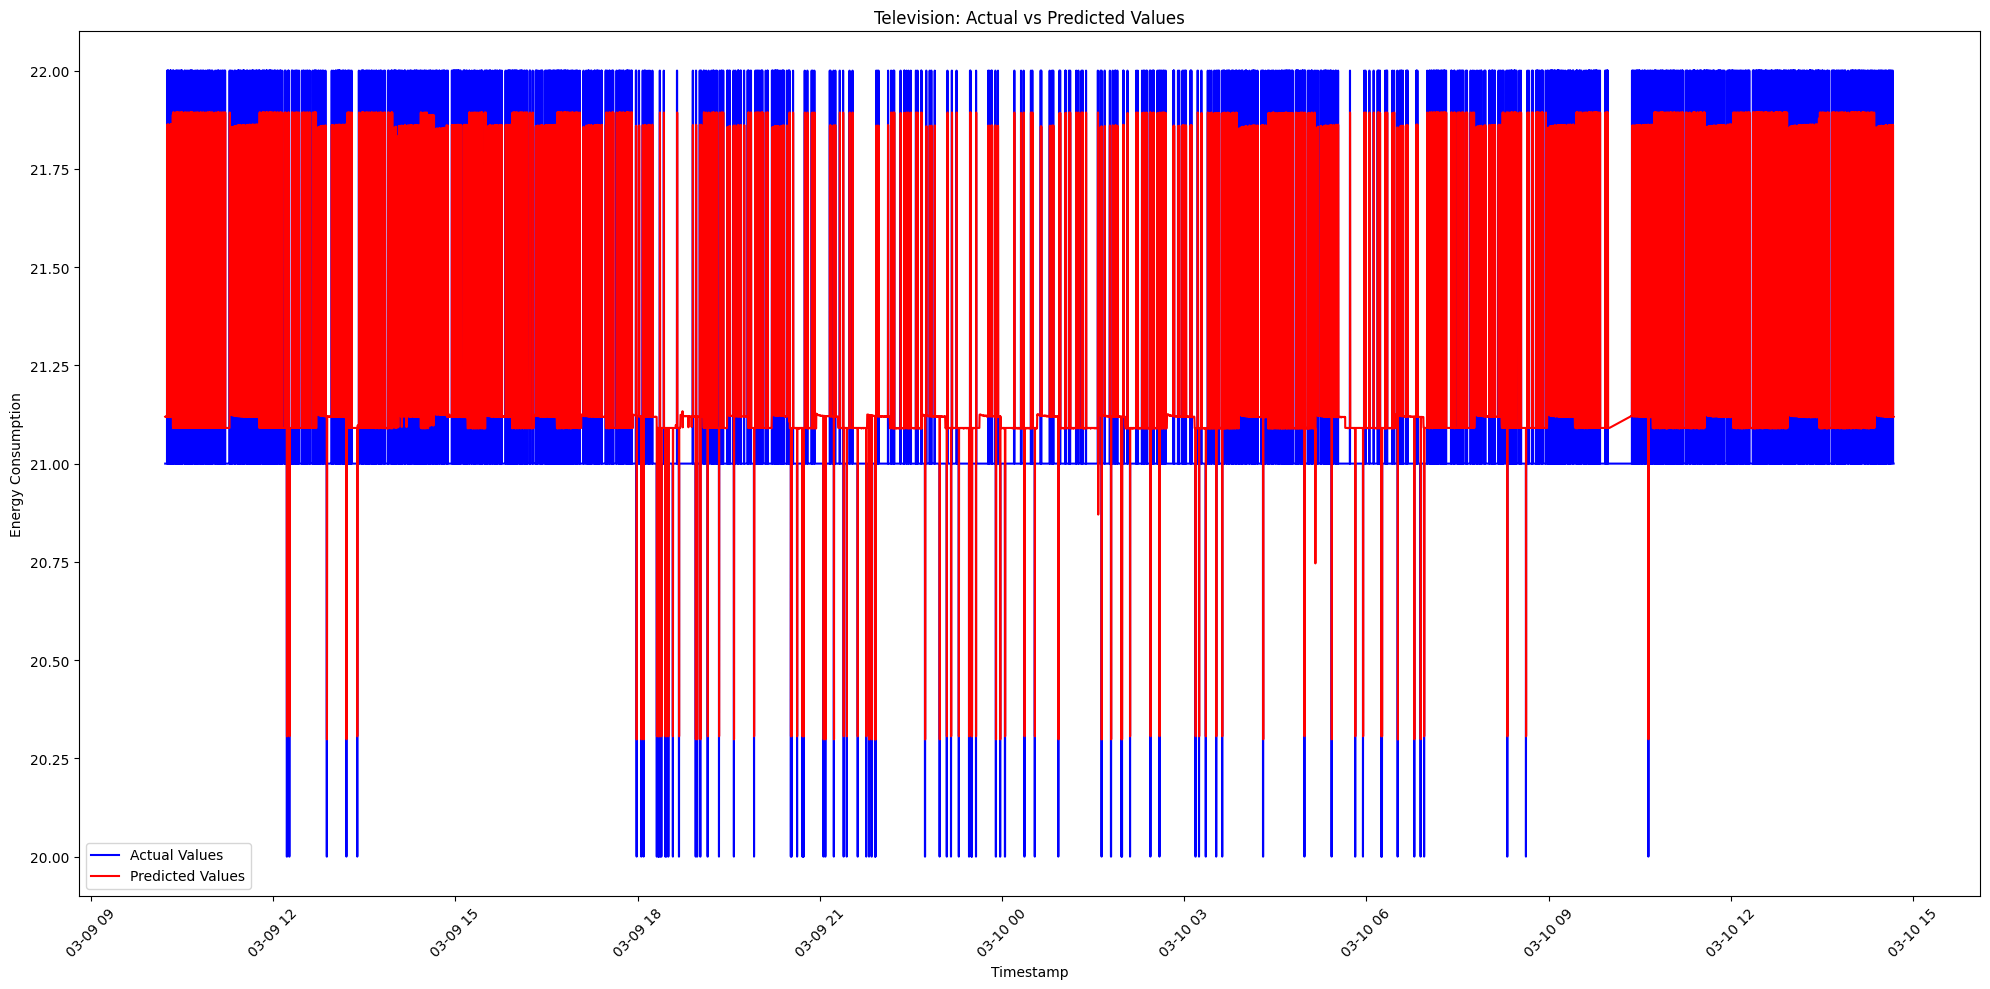

In [ ]:
# Plot actual and predicted values


plt.figure(figsize=(20, 10))
plt.plot(tv_output['Timestamp'], tv_output['Actual Values'], label='Actual Values', color='blue')
plt.plot(tv_output['Timestamp'], tv_output['Predicted Values'], label='Predicted Values', color='red')
plt.title('Television: Actual vs Predicted Values')
plt.xlabel('Timestamp')
plt.ylabel('Energy Consumption')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [71]:
import pandas as pd
from sklearn.metrics import mean_absolute_error


mae_microwave = mean_absolute_error(actual_values[:, 2], predictions[:, 2])

timestamp_index = test_data[1].index[:len(predictions)]

microwave_output = pd.DataFrame({
    'Timestamp': timestamp_index,
    'Actual Values': actual_values[:, 2],
    'Predicted Values': predictions[:, 2]
})

# Add the accuracy metric (MAE) to the DataFrame
microwave_output['MAE'] = mae_microwave

print("Microwave:")
print(microwave_output.head(20))

print(f"Mean Absolute Error (Microwave): {mae_microwave:.4f}") 


Microwave:
             Timestamp  Actual Values  Predicted Values       MAE
0  2014-03-09 10:13:13            2.0          3.378548  4.673821
1  2014-03-09 10:13:15            2.0          3.347880  4.673821
2  2014-03-09 10:13:20            2.0          3.347880  4.673821
3  2014-03-09 10:13:27            2.0          3.347880  4.673821
4  2014-03-09 10:13:29            2.0          3.347880  4.673821
5  2014-03-09 10:13:34            2.0          3.378548  4.673821
6  2014-03-09 10:13:43            2.0          3.347880  4.673821
7  2014-03-09 10:13:48            2.0          3.378548  4.673821
8  2014-03-09 10:13:57            2.0          3.317249  4.673821
9  2014-03-09 10:14:02            2.0          3.317249  4.673821
10 2014-03-09 10:14:12            2.0          3.378548  4.673821
11 2014-03-09 10:14:16            2.0          3.347880  4.673821
12 2014-03-09 10:14:19            2.0          3.347880  4.673821
13 2014-03-09 10:14:26            2.0          3.347880  4.673821

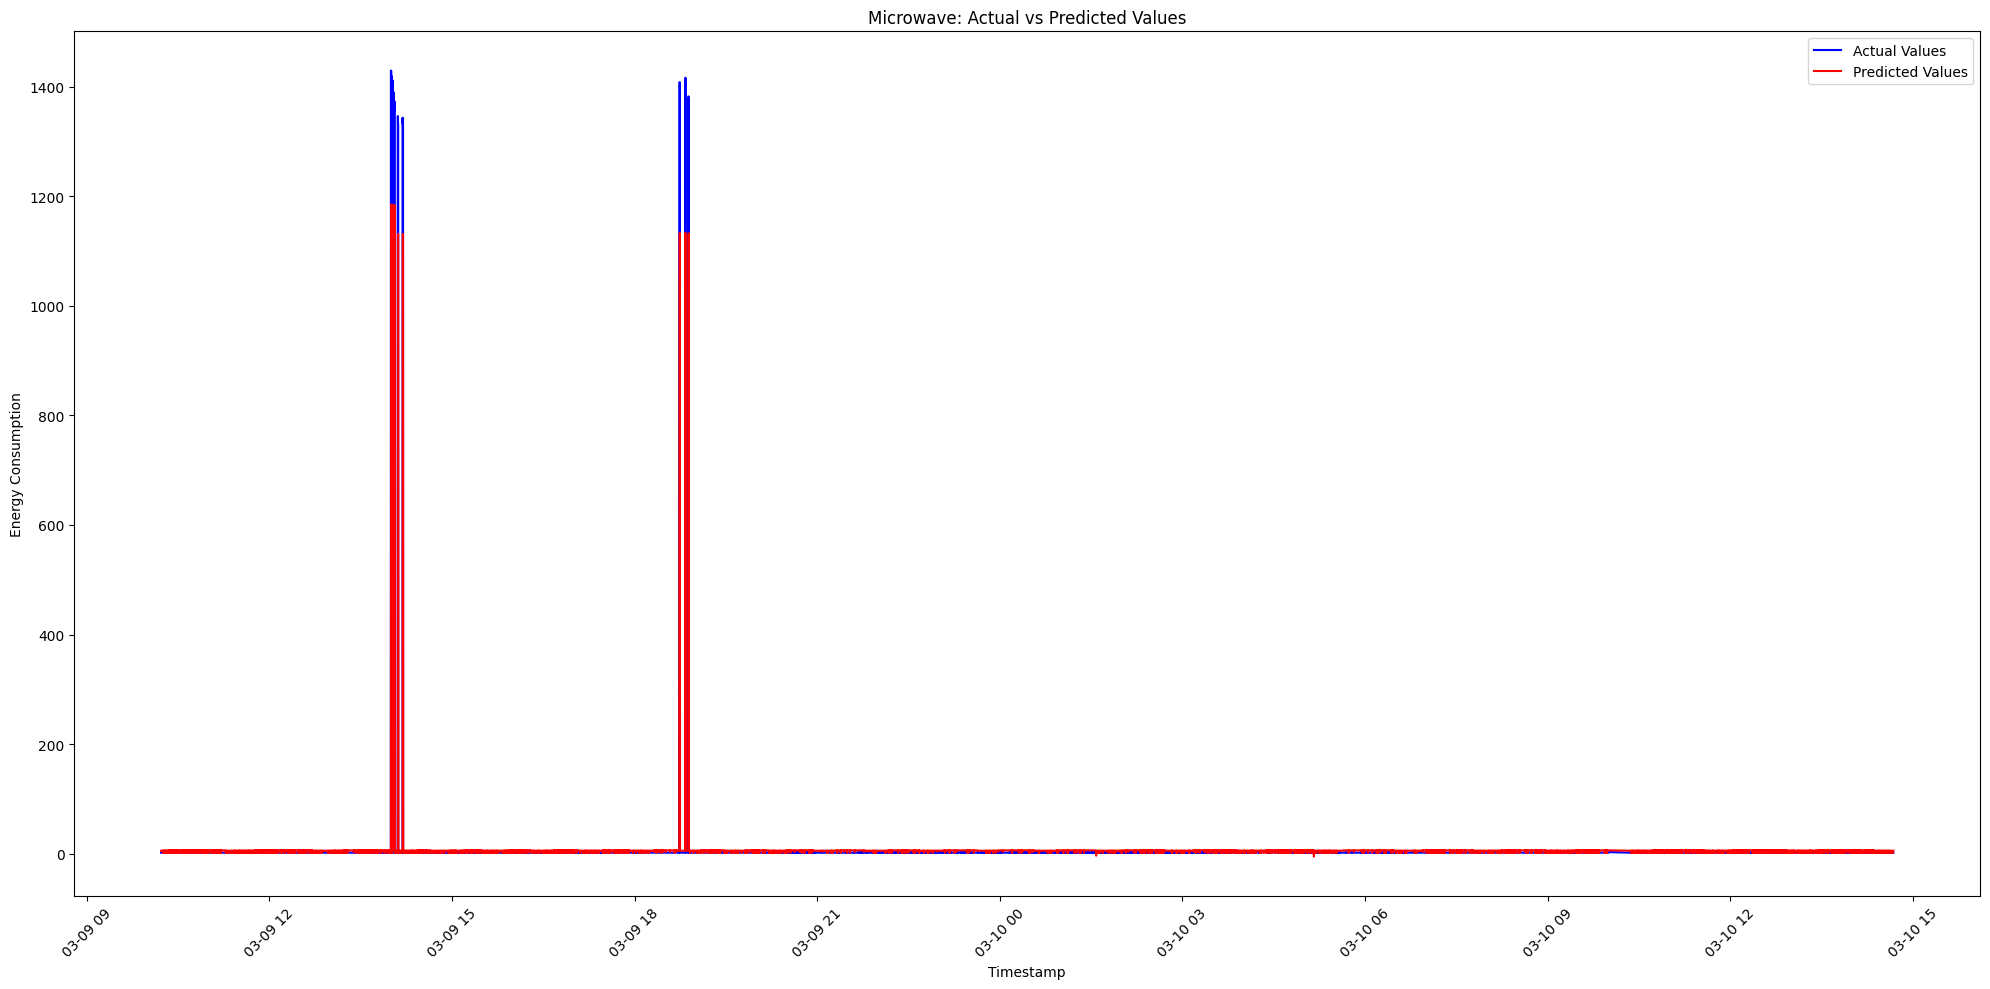

In [ ]:
# Plot actual and predicted values

plt.figure(figsize=(20, 10))
plt.plot(microwave_output['Timestamp'], microwave_output['Actual Values'], label='Actual Values', color='blue')
plt.plot(microwave_output['Timestamp'], microwave_output['Predicted Values'], label='Predicted Values', color='red')
plt.title('Microwave: Actual vs Predicted Values')
plt.xlabel('Timestamp')
plt.ylabel('Energy Consumption')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



## BIDIRECTIONAL LSTM

In [37]:
# Bidirectional LSTM model architecture

def build_bidirectional_lstm_model(input_shape):
    bidirectional_model = Sequential([
        Bidirectional(LSTM(units=64), input_shape=input_shape),
        Dense(units=3)
    ])
    return bidirectional_model


bidirectional_model = build_bidirectional_lstm_model(input_shape=(train_X[1].shape[1], train_X[1].shape[2]))

bidirectional_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirecti  (None, 128)               34816     
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 3)                 387       
                                                                 
Total params: 35203 (137.51 KB)
Trainable params: 35203 (137.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [38]:
# Define the learning rate
learning_rate = 0.001

optimizer = Adam(learning_rate=learning_rate)

# Compile the bidirectional LSTM mode
bidirectional_model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])




In [39]:
# Train the bidirectional LSTM model
history_bi = bidirectional_model.fit(train_X[1], train_y[1], epochs=100, batch_size=32, validation_data=(test_X[1], test_y[1]))


Epoch 1/100
1220/1220 [==============================] - 9s 4ms/step - loss: 0.0010 - accuracy: 0.9960 - val_loss: 0.0141 - val_accuracy: 0.9903
Epoch 2/100
1220/1220 [==============================] - 4s 3ms/step - loss: 3.1662e-04 - accuracy: 0.9988 - val_loss: 0.0140 - val_accuracy: 0.9903
Epoch 3/100
1220/1220 [==============================] - 4s 3ms/step - loss: 3.1926e-04 - accuracy: 0.9988 - val_loss: 0.0137 - val_accuracy: 0.9903
Epoch 4/100
1220/1220 [==============================] - 4s 3ms/step - loss: 3.1819e-04 - accuracy: 0.9987 - val_loss: 0.0140 - val_accuracy: 0.9903
Epoch 5/100
1220/1220 [==============================] - 4s 3ms/step - loss: 3.1464e-04 - accuracy: 0.9988 - val_loss: 0.0134 - val_accuracy: 0.9903
Epoch 6/100
1220/1220 [==============================] - 4s 3ms/step - loss: 3.1619e-04 - accuracy: 0.9988 - val_loss: 0.0137 - val_accuracy: 0.9903
Epoch 7/100
1220/1220 [==============================] - 4s 3ms/step - loss: 3.1679e-04 - accuracy: 0.9988 - v

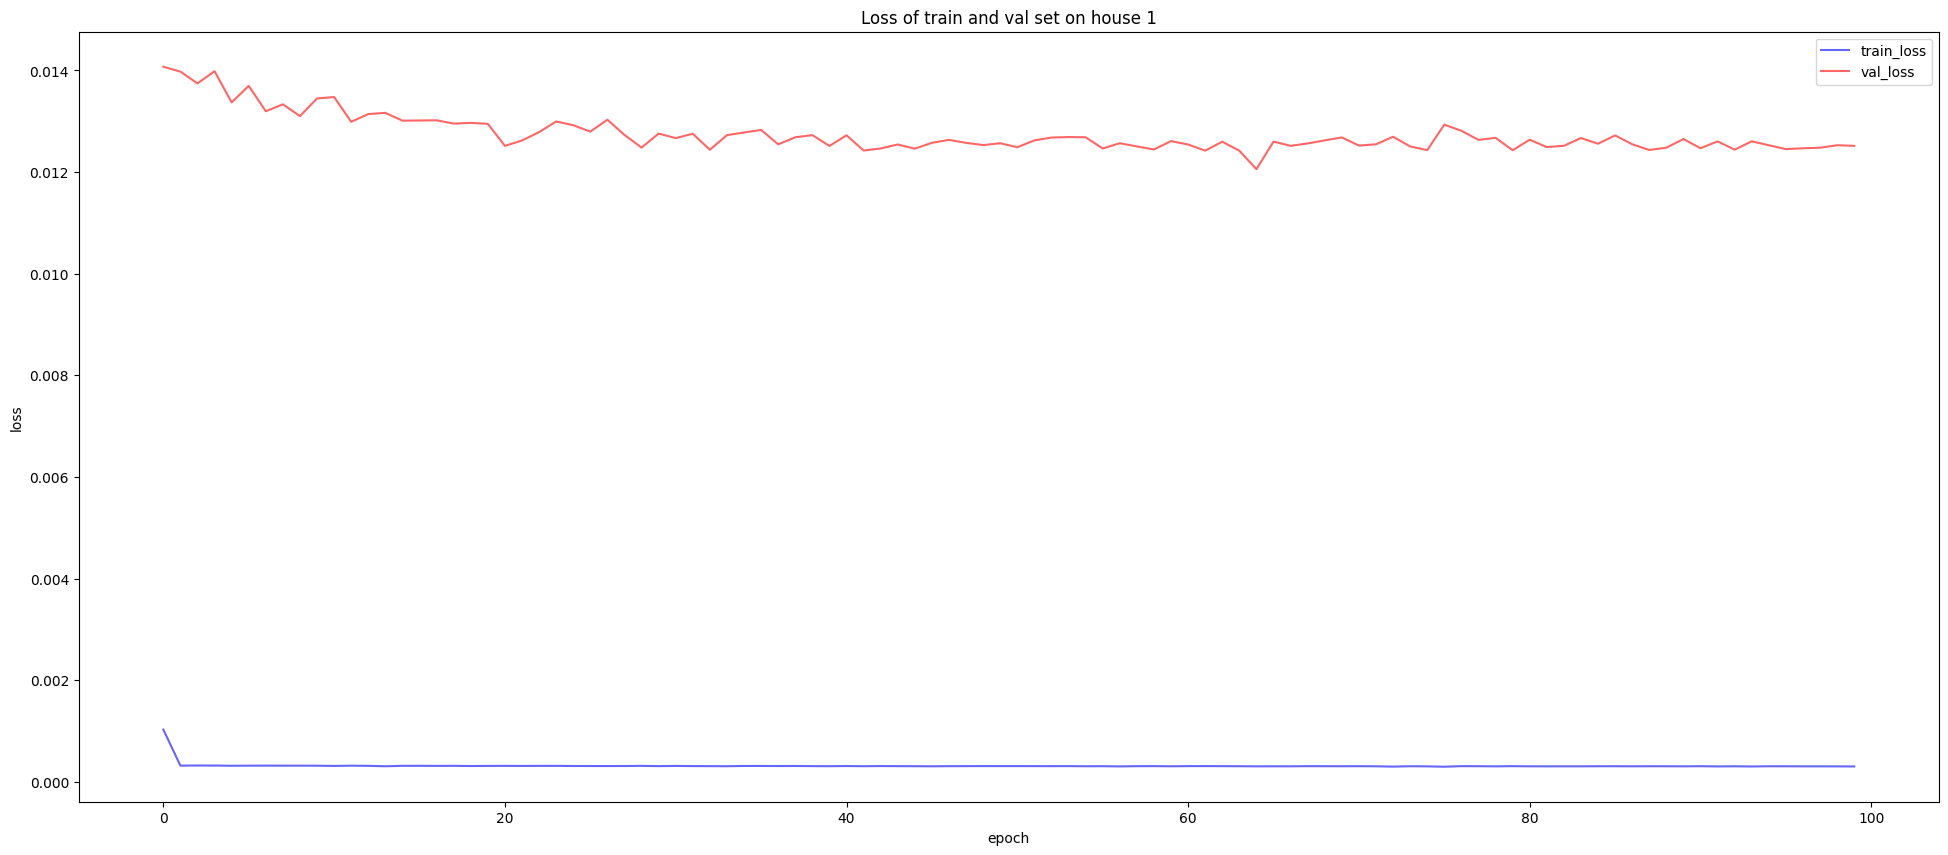

In [40]:
train_loss = history_bi.history['loss']
val_loss = history_bi.history['val_loss']
def plot_losses(train_loss, val_loss):
    plt.rcParams["figure.figsize"] = [24,10]
    plt.title('Loss of train and val set on house 1')
    plt.plot( range(len(train_loss)), train_loss, color = 'b', alpha = 0.6, label='train_loss' )
    plt.plot( range(len( val_loss )), val_loss, color = 'r', alpha = 0.6, label='val_loss' )
    plt.xlabel( 'epoch' )
    plt.ylabel( 'loss' )
    plt.legend()

plot_losses(train_loss, val_loss)

In [ ]:
# Save the model
bidirectional_model.save('bidirectional_model.h5')


In [ ]:
# Evaluataccuracye the model on Train data
loss, accuracy = bidirectional_model.evaluate(train_X[1], train_y[1])
print("Train Loss:", loss)
print("Train Accuracy: ", accuracy)

1220/1220 [==============================] - 2s 2ms/step - loss: 2.9321e-04 - accuracy: 0.9988
Train Loss: 0.0002932116331066936
Train Accuracy:  0.9987958669662476


In [ ]:
# Evaluate the model on test data
loss, accuracy = bidirectional_model.evaluate(test_X[1], test_y[1])
print("Test Loss:", loss)
print("Test Accuracy: ", accuracy)

523/523 [==============================] - 1s 2ms/step - loss: 0.0125 - accuracy: 0.9872
Test Loss: 0.012508364394307137
Test Accuracy:  0.9872070550918579


In [ ]:
# Predict energy consumption using the trained LSTM model
predictions = bidirectional_model.predict(test_X[1])


# Inverse transform predictions using the scaler
predictions = test_scalers[1].inverse_transform(predictions)


# Inverse transform the actual values to get the original scale of energy consumption
actual_values = test_scalers[1].inverse_transform(test_y[1])


mse = mean_squared_error(actual_values, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_y[1], predictions)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)

523/523 [==============================] - 1s 2ms/step
Mean Squared Error (MSE): 679.4248709715304
Root Mean Squared Error (RMSE): 26.065779692376946
Mean Absolute Error (MAE): 19.956039756359036


In [42]:
import pandas as pd
from sklearn.metrics import mean_absolute_error


mae_fridge = mean_absolute_error(actual_values[:, 0], predictions[:, 0])

timestamp_index = test_data[1].index[:len(predictions)]

fridge_output = pd.DataFrame({
    'Timestamp': timestamp_index,
    'Actual Values': actual_values[:, 0],
    'Predicted Values': predictions[:, 0]
})

# Add the accuracy metric (MAE) to the DataFrame
fridge_output['MAE'] = mae_fridge

print("Fridge:")
print(fridge_output.head(20))

# Print the Mean Absolute Error
print(f"Mean Absolute Error (Fridge): {mae_fridge:.4f}")


Fridge:
             Timestamp  Actual Values  Predicted Values       MAE
0  2014-03-09 10:13:13           73.0         73.775513  1.637878
1  2014-03-09 10:13:15           73.0         72.800148  1.637878
2  2014-03-09 10:13:20           73.0         72.800148  1.637878
3  2014-03-09 10:13:27           73.0         72.800148  1.637878
4  2014-03-09 10:13:29           74.0         72.800148  1.637878
5  2014-03-09 10:13:34           73.0         73.775513  1.637878
6  2014-03-09 10:13:43           74.0         72.800148  1.637878
7  2014-03-09 10:13:48           72.0         73.775513  1.637878
8  2014-03-09 10:13:57           72.0         71.823692  1.637878
9  2014-03-09 10:14:02           74.0         71.823692  1.637878
10 2014-03-09 10:14:12           73.0         73.775513  1.637878
11 2014-03-09 10:14:16           73.0         72.800148  1.637878
12 2014-03-09 10:14:19           73.0         72.800148  1.637878
13 2014-03-09 10:14:26           74.0         72.800148  1.637878
14

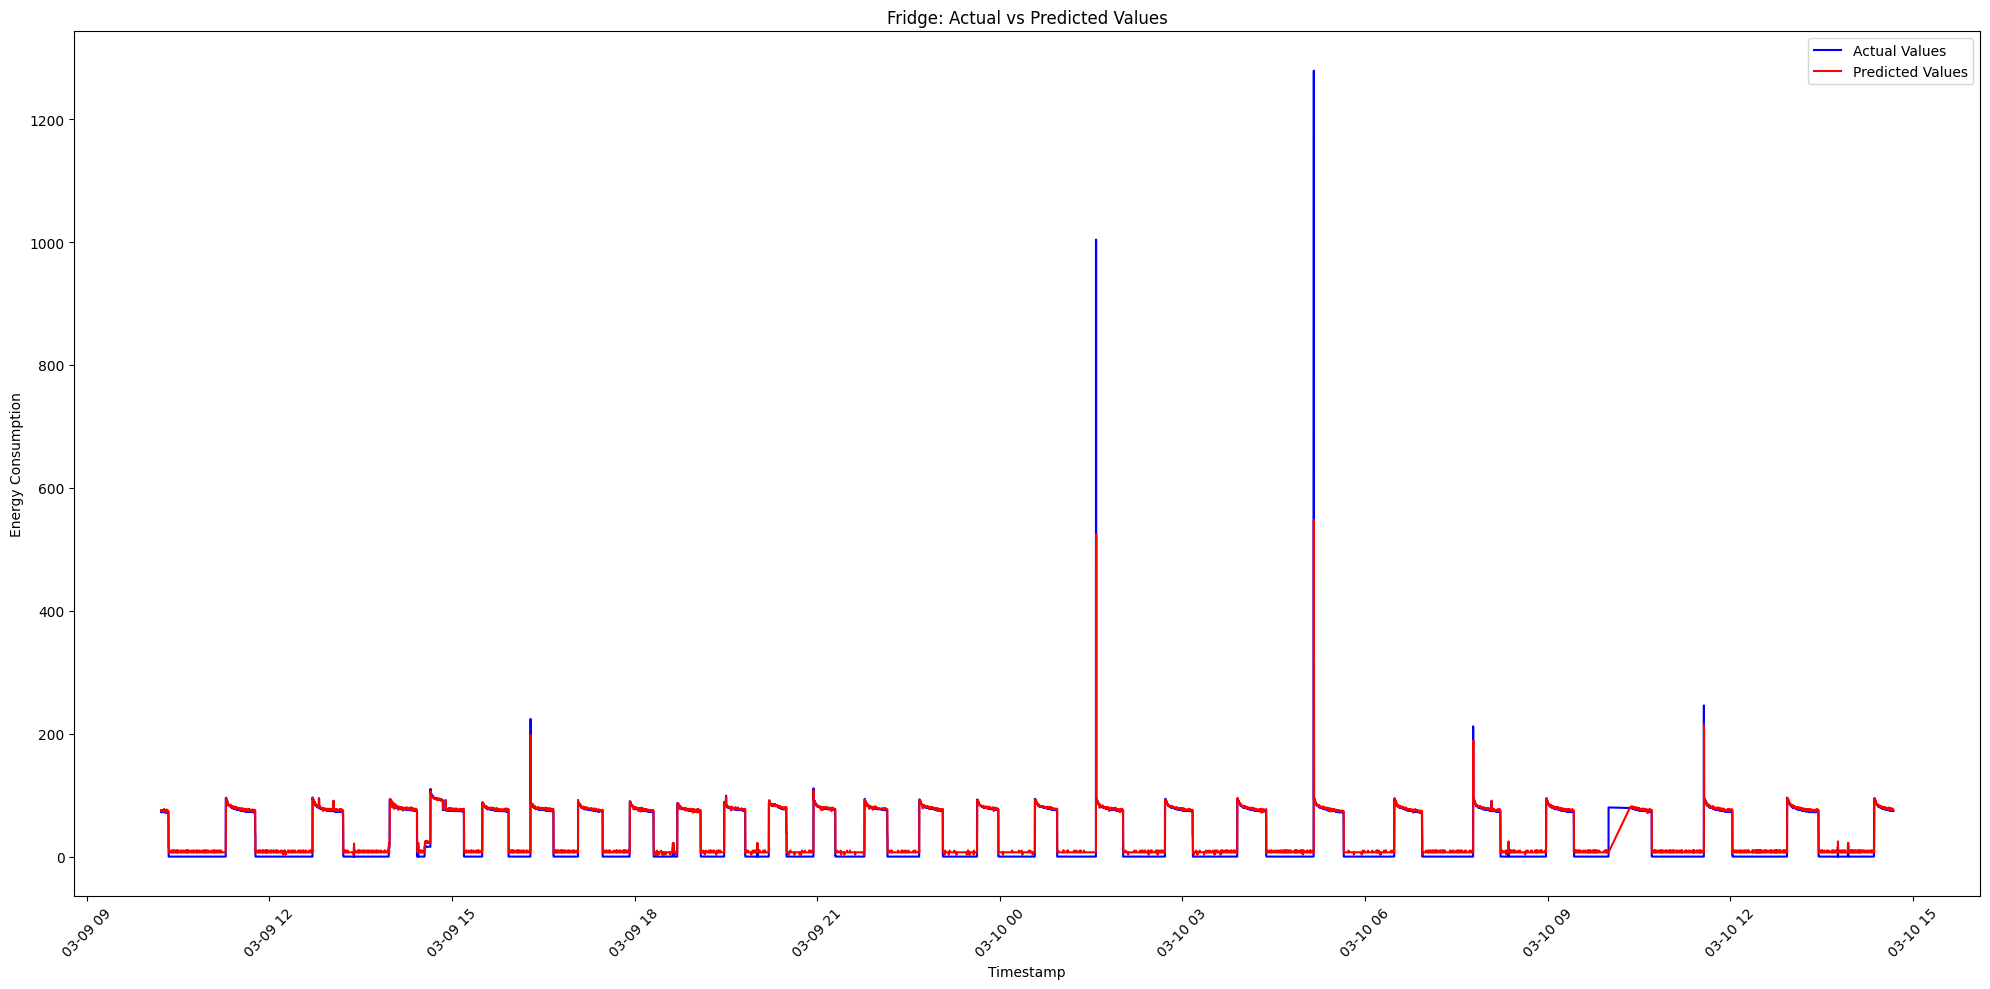

In [ ]:
# Plot actual and predicted values

plt.figure(figsize=(20, 10))
plt.plot(fridge_output['Timestamp'], fridge_output['Actual Values'], label='Actual Values', color='blue')
plt.plot(fridge_output['Timestamp'], fridge_output['Predicted Values'], label='Predicted Values', color='red')
plt.title('Fridge: Actual vs Predicted Values')
plt.xlabel('Timestamp')
plt.ylabel('Energy Consumption')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [70]:
mae_tv = mean_absolute_error(actual_values[:, 1], predictions[:, 1])

timestamp_index = test_data[1].index[:len(predictions)]

tv_output = pd.DataFrame({
    'Timestamp': timestamp_index,
    'Actual Values': actual_values[:, 1],
    'Predicted Values': predictions[:, 1]
})


tv_output['MAE'] = mae_tv

print("Television:")
print(tv_output.head(20))

print(f"Mean Absolute Error (Television): {mae_tv:.4f}")


Television:
             Timestamp  Actual Values  Predicted Values       MAE
0  2014-03-09 10:13:13           21.0         21.012409  0.161926
1  2014-03-09 10:13:15           21.0         21.012413  0.161926
2  2014-03-09 10:13:20           21.0         21.012413  0.161926
3  2014-03-09 10:13:27           21.0         21.012413  0.161926
4  2014-03-09 10:13:29           21.0         21.012413  0.161926
5  2014-03-09 10:13:34           21.0         21.012409  0.161926
6  2014-03-09 10:13:43           21.0         21.012413  0.161926
7  2014-03-09 10:13:48           21.0         21.012409  0.161926
8  2014-03-09 10:13:57           21.0         21.012415  0.161926
9  2014-03-09 10:14:02           21.0         21.012415  0.161926
10 2014-03-09 10:14:12           21.0         21.012409  0.161926
11 2014-03-09 10:14:16           21.0         21.012413  0.161926
12 2014-03-09 10:14:19           21.0         21.012413  0.161926
13 2014-03-09 10:14:26           21.0         21.012413  0.16192

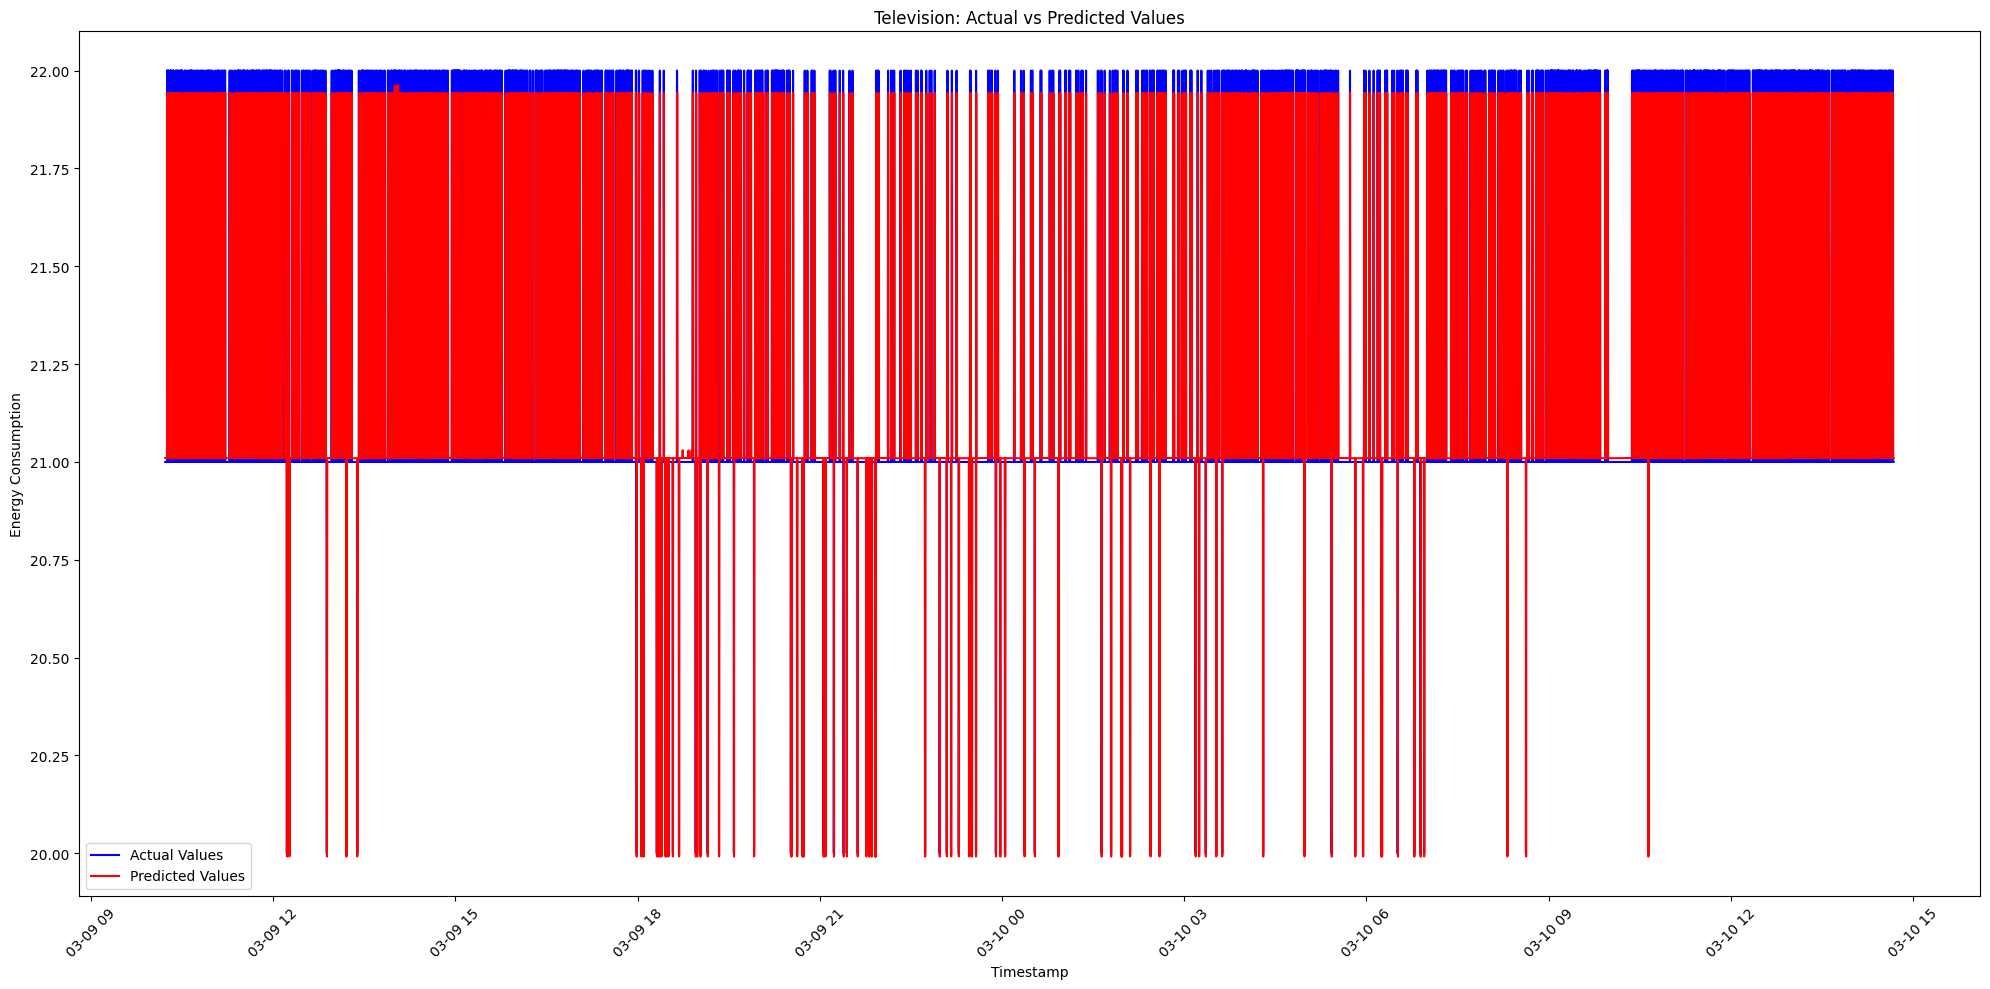

In [ ]:
# Plot actual and predicted values


plt.figure(figsize=(20, 10))
plt.plot(tv_output['Timestamp'], tv_output['Actual Values'], label='Actual Values', color='blue')
plt.plot(tv_output['Timestamp'], tv_output['Predicted Values'], label='Predicted Values', color='red')
plt.title('Television: Actual vs Predicted Values')
plt.xlabel('Timestamp')
plt.ylabel('Energy Consumption')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
mae_microwave = mean_absolute_error(actual_values[:, 2], predictions[:, 2])

timestamp_index = test_data[1].index[:len(predictions)]

microwave_output = pd.DataFrame({
    'Timestamp': timestamp_index,
    'Actual Values': actual_values[:, 2],
    'Predicted Values': predictions[:, 2]
})

microwave_output['MAE'] = mae_microwave

print("Microwave:")
print(microwave_output.head(20))


print(f"Mean Absolute Error (Microwave): {mae_microwave:.4f}")


Microwave:
             Timestamp  Actual Values  Predicted Values       MAE
0  2014-03-09 10:13:13            2.0          0.003543  5.794216
1  2014-03-09 10:13:15            2.0          0.003556  5.794216
2  2014-03-09 10:13:20            2.0          0.003556  5.794216
3  2014-03-09 10:13:27            2.0          0.003556  5.794216
4  2014-03-09 10:13:29            2.0          0.003556  5.794216
5  2014-03-09 10:13:34            2.0          0.003543  5.794216
6  2014-03-09 10:13:43            2.0          0.003556  5.794216
7  2014-03-09 10:13:48            2.0          0.003543  5.794216
8  2014-03-09 10:13:57            2.0          0.003568  5.794216
9  2014-03-09 10:14:02            2.0          0.003568  5.794216
10 2014-03-09 10:14:12            2.0          0.003543  5.794216
11 2014-03-09 10:14:16            2.0          0.003556  5.794216
12 2014-03-09 10:14:19            2.0          0.003556  5.794216
13 2014-03-09 10:14:26            2.0          0.003556  5.794216

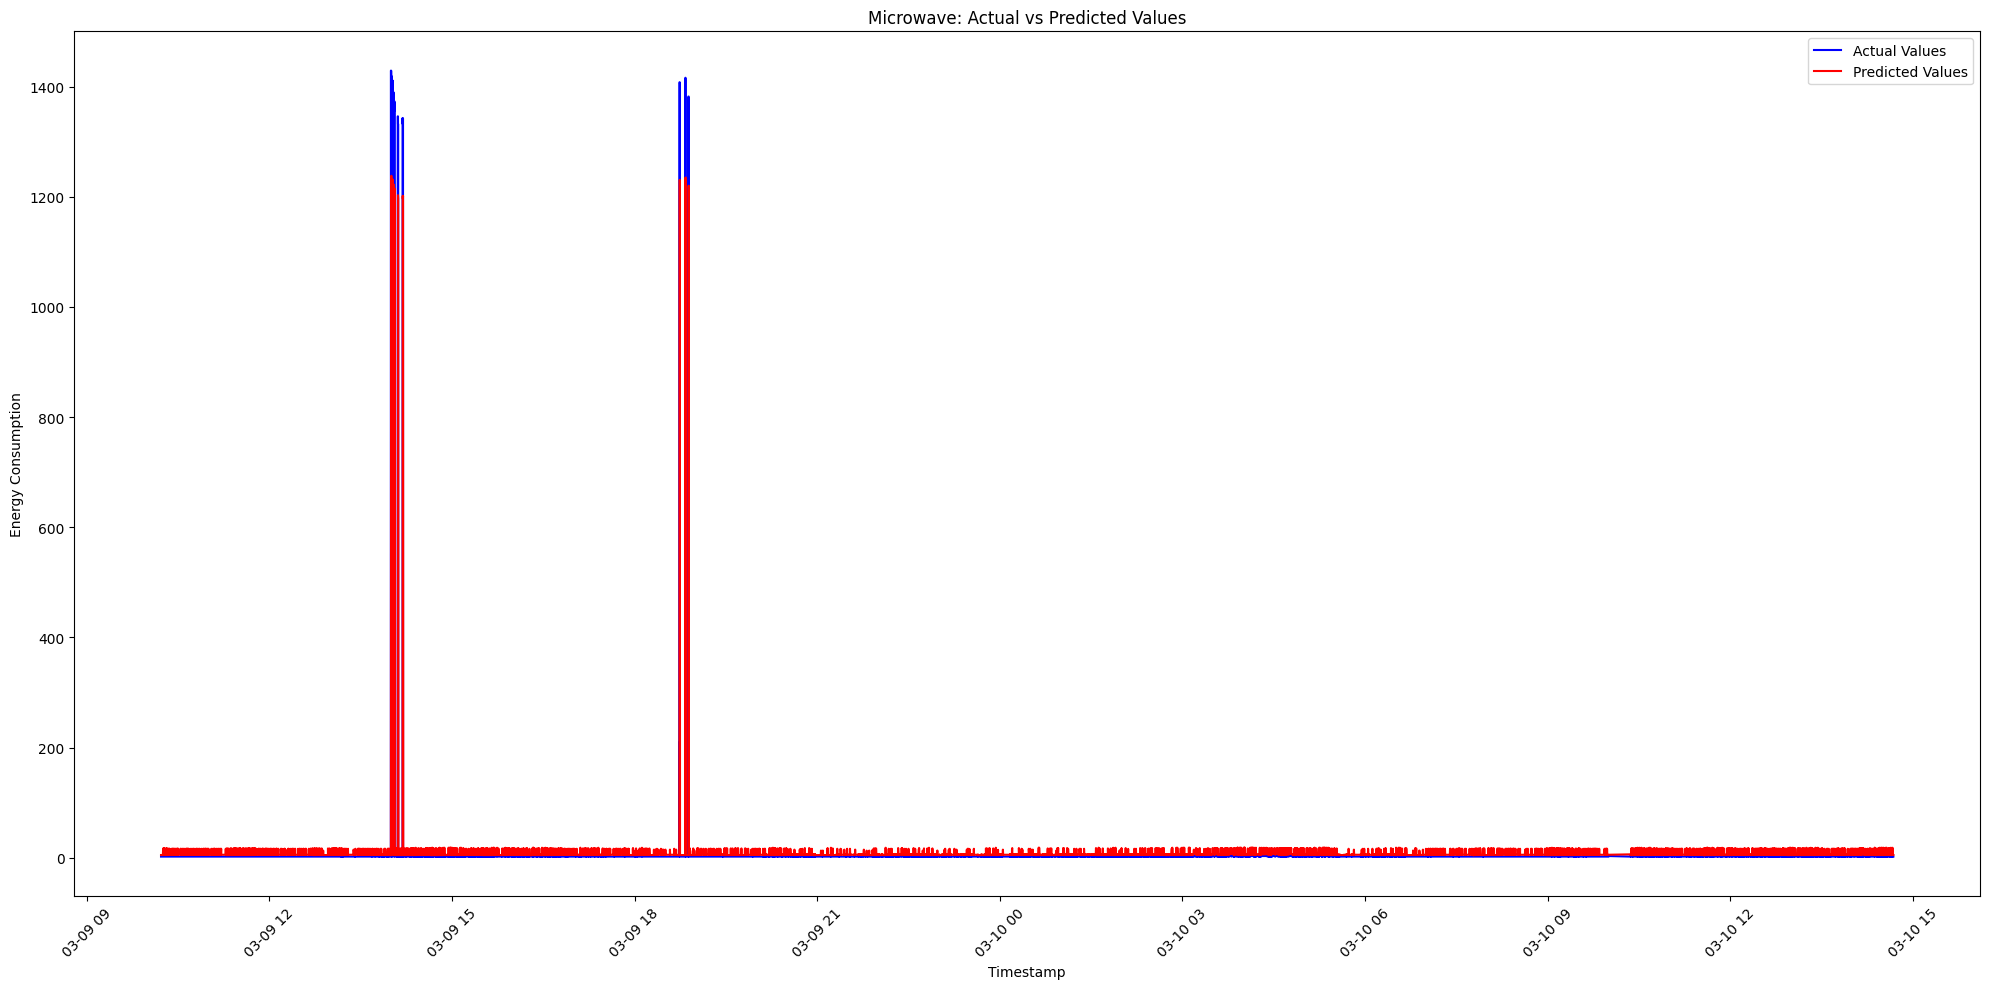

In [ ]:
# Plot actual and predicted values



plt.figure(figsize=(20, 10))
plt.plot(microwave_output['Timestamp'], microwave_output['Actual Values'], label='Actual Values', color='blue')
plt.plot(microwave_output['Timestamp'], microwave_output['Predicted Values'], label='Predicted Values', color='red')
plt.title('Microwave: Actual vs Predicted Values')
plt.xlabel('Timestamp')
plt.ylabel('Energy Consumption')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()